# Исследование данных интернет-магазина "В один клик".

Заказчик исследования — интернет-магазин «В один клик». Компания продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты.

Цель исследования - разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Используемые данные: 
 - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении;
 - данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом;
 - данные о времени, которое покупатель провёл на сайте в течение периода;
 - данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

## Импорт необходимых библиотек и модулей

In [1]:
!pip install matplotlib==3.5.0 -U -q # -q убирает необязательные выводы в командах Linux
!pip install -U scikit-learn -q
!pip install shap -q
!pip install phik -q


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


from phik.report import plot_correlation_matrix

In [3]:
# обьявляем константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
# настраиваем отображение таблиц
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Загрузка данных

In [5]:
# загружаем данные и присваем дафреймам имена
df_market_file = pd.read_csv('/datasets/market_file.csv', sep=',', decimal='.')
df_market_file.name='df_market_file'
df_market_money = pd.read_csv('/datasets/market_money.csv', sep=',', decimal='.')
df_market_money.name='df_market_money'
df_market_time = pd.read_csv('/datasets/market_time.csv', sep=',', decimal='.')
df_market_time.name='df_market_time'
df_money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
df_money.name='df_money'

In [6]:
# обьединим данные в список для ускорения дальнейшей обработки
df_list=[df_market_file, df_market_money, df_market_time, df_money]

In [7]:
for df in df_list:
    #приведем названия колонок к единому стилю
    df.columns = [x.lower() for x in df.columns]
    df.columns = [x.replace(' ', '_') for x in df.columns]
    print(f'Первые пять строчек датафрейма {df.name}:')
    display(df.head())
    print()
    print(f'Общая информация о датафрейме {df.name}:')
    df.info()
    print()
    

Первые пять строчек датафрейма df_market_file:


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2



Общая информация о датафрейме df_market_file:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-nul

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6



Общая информация о датафрейме df_market_money:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB

Первые пять строчек датафрейма df_market_time:


,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13



Общая информация о датафрейме df_market_time:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB

Первые пять строчек датафрейма df_money:


,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21



Общая информация о датафрейме df_money:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB



**Промежуточные выводы:**
- привели названия колонок к единому виду(строчные буквы и змеиный регистр);
- пропусков в данных не обнаружено, типизация данных во всех датафреймах корректна.


## Предобработка данных

In [8]:
# циклом проходимся по всем датафреймам для поиска явных дубликатов
for df in df_list:
    print(f'Количество явных дубликатов в {df.name} - {df.duplicated().sum()}')

Количество явных дубликатов в df_market_file - 0
Количество явных дубликатов в df_market_money - 0
Количество явных дубликатов в df_market_time - 0
Количество явных дубликатов в df_money - 0


In [9]:
# смотрим неявные дубликаты и коррекность значений 
for df in df_list:
    for column in df.select_dtypes(exclude=np.number).columns.to_list():
        print(f' Список уникальных значений столбца "{column}" датафрейма {df.name}')
        print(df[column].unique())
        print()

 Список уникальных значений столбца "покупательская_активность" датафрейма df_market_file
['Снизилась' 'Прежний уровень']

 Список уникальных значений столбца "тип_сервиса" датафрейма df_market_file
['премиум' 'стандартт' 'стандарт']

 Список уникальных значений столбца "разрешить_сообщать" датафрейма df_market_file
['да' 'нет']

 Список уникальных значений столбца "популярная_категория" датафрейма df_market_file
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

 Список уникальных значений столбца "период" датафрейма df_market_money
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

 Список уникальных значений столбца "период" датафрейма df_market_time
['текущий_месяц' 'предыдцщий_месяц']



In [10]:
# исправим неявные дубликаты и явные орфоргафические ошибки
df_market_file['тип_сервиса'] = df_market_file['тип_сервиса'].replace('стандартт', 'стандарт')

df_market_time['период'] = df_market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [11]:
# проверяем, что замены были произведены корректно
print(df_market_file['тип_сервиса'].unique())
print(df_market_time['период'].unique())

['премиум' 'стандарт']
['текущий_месяц' 'предыдущий_месяц']


**Промежуточные выводы:**
- явные дубликаты не обнаружены;
- исправлены невные дубикаты названий в df_market_file и опечатки в df_market_time.

## Исследовательский анализ данных

In [12]:
def distribution_plots(df, sign):
    """Функция для построения графиков распределения количественных признаков."""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7), dpi=100)
    sns.histplot(data=df[sign], color='darkgreen',ax=axes[0])
    sns.boxplot(data=df[sign], color='darkgreen',ax=axes[1])
    axes[0].grid(True)
    axes[1].grid(True)
    print(f'Графики распределения количественного признака "{sign}"')
    plt.show()
    print(df[sign].describe())
    print()


In [13]:
def categotial_plots(df,sign):
    '''Функция для построения графиков распределения катерогиальных признаков.'''
    data=df[sign].value_counts()
    print(f'График распределения категориального признака "{column}"')
    print()
    print(data)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,10), dpi=100)
    data.plot(kind='pie',
              autopct='%.1f%%',
              label='',
              colormap='summer',
              labels=['',]*len(data),
              legend=True,
              figsize=(6, 6),
              ax=axes[0])
    data.plot(kind='barh',
              colormap='summer',
              figsize=(15, 3),             
              ax=axes[1],
              grid=True)
    fig.subplots_adjust(left=None,
                        bottom=None,
                        right=None,
                        top=None,
                        wspace=0.3,
                        hspace=0.3,)
    
    axes[0].legend(loc=(0, 1.2), labels=data.index)
    for i in axes[1].patches:
        plt.text(i.get_width()-100, i.get_y()+0.2,
                 str(round((i.get_width()), 2)),
                 fontsize=12)
        
    plt.show()
    print()    

### Исследовательский анализ данных для df_market_file

Графики распределения количественного признака "маркет_актив_6_мес"


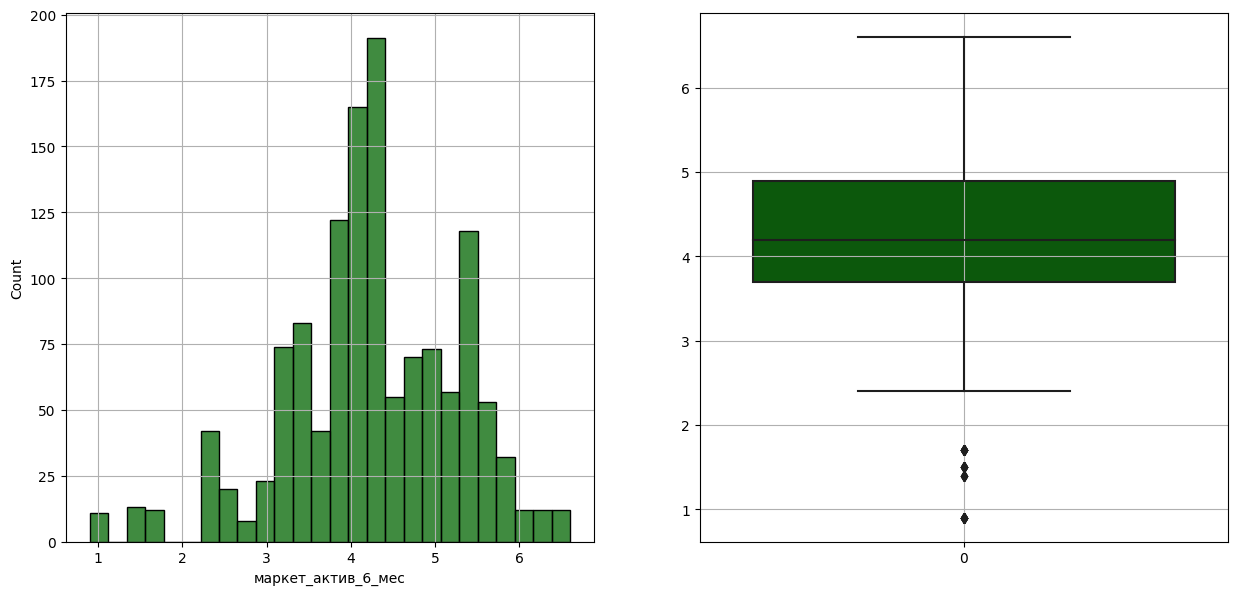

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

Графики распределения количественного признака "маркет_актив_тек_мес"


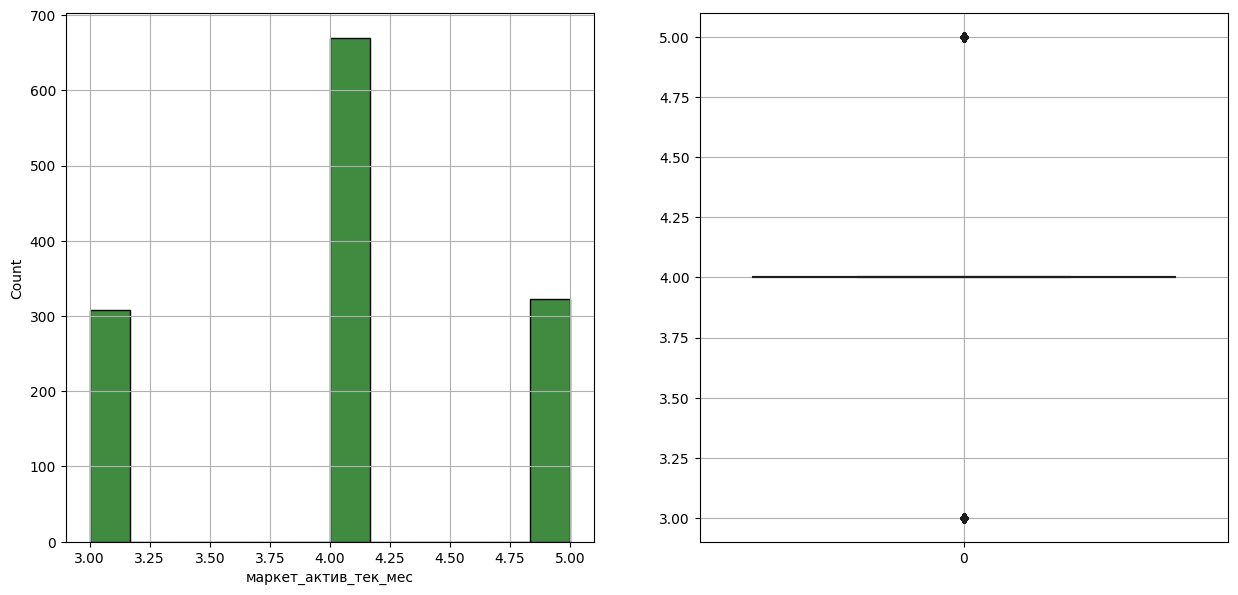

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64

Графики распределения количественного признака "длительность"


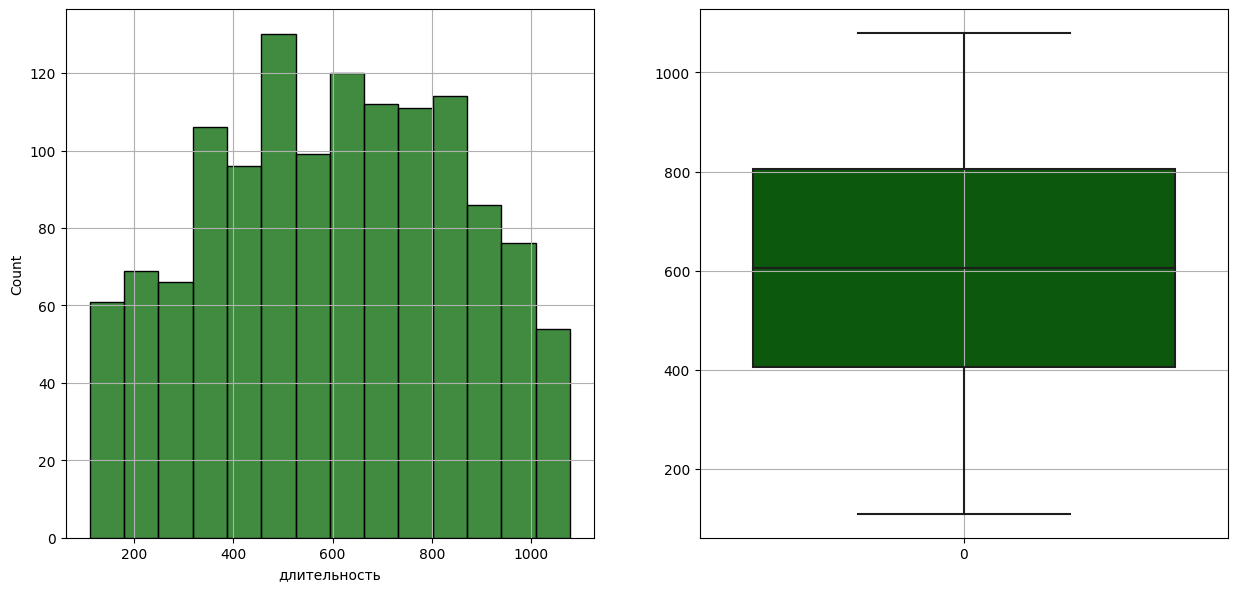

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64

Графики распределения количественного признака "акционные_покупки"


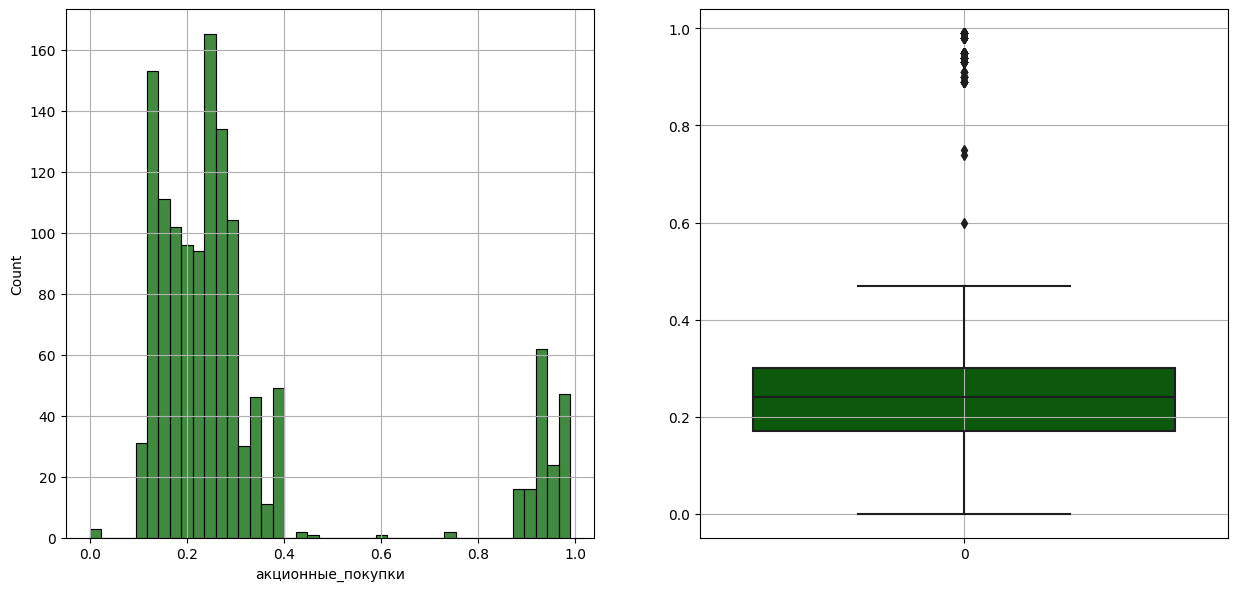

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

Графики распределения количественного признака "средний_просмотр_категорий_за_визит"


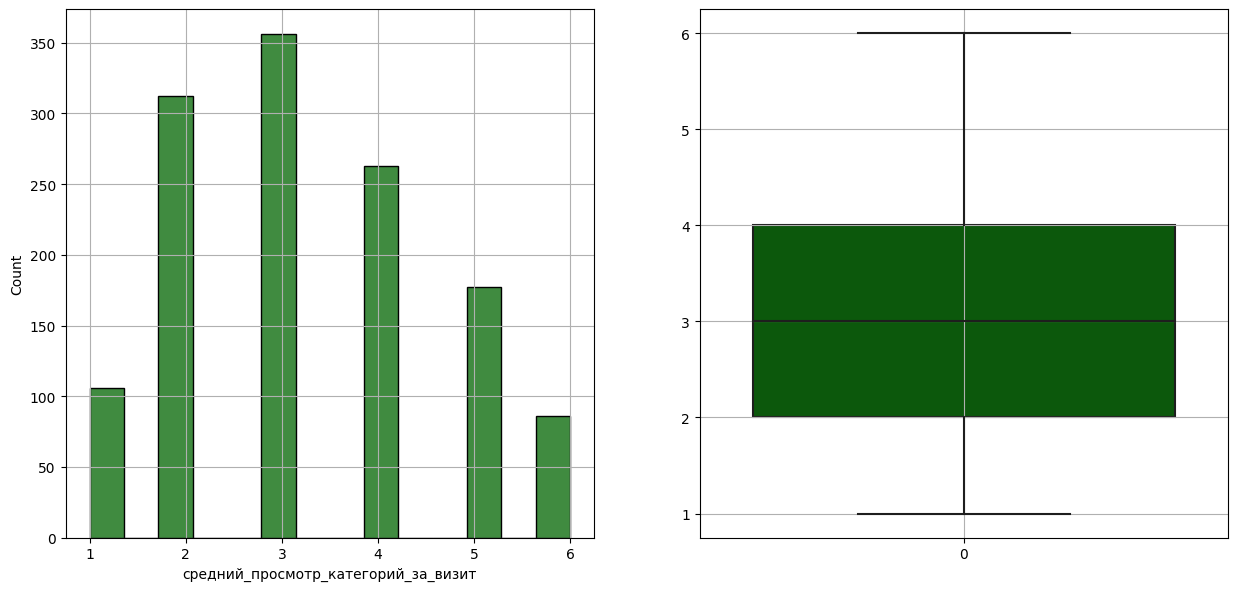

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64

Графики распределения количественного признака "неоплаченные_продукты_штук_квартал"


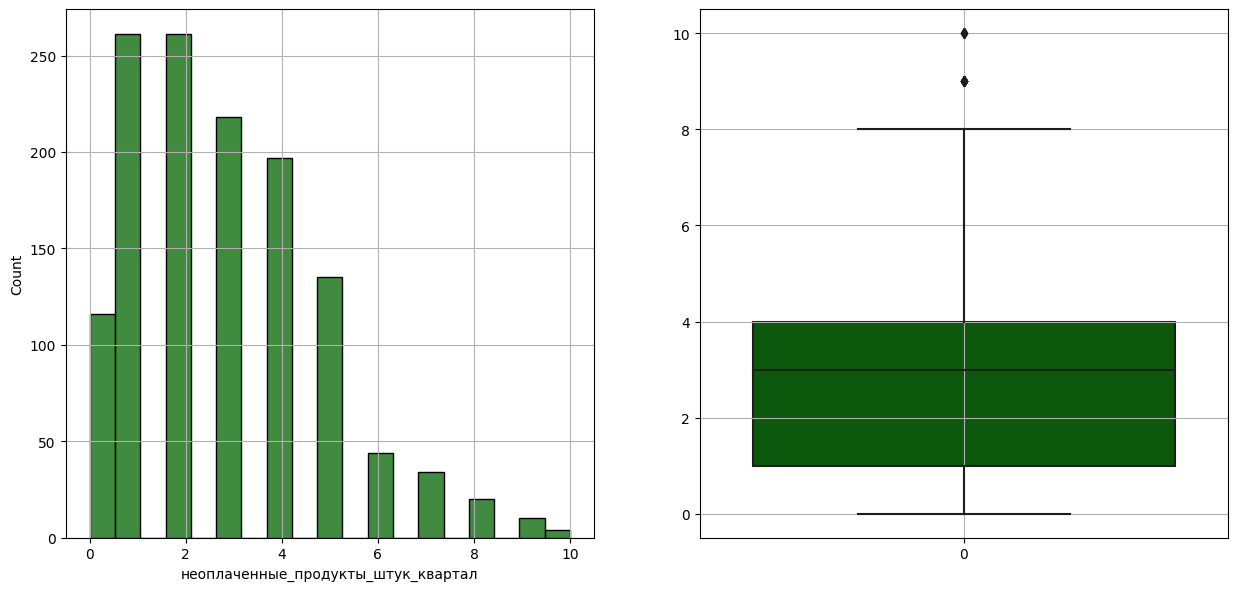

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

Графики распределения количественного признака "ошибка_сервиса"


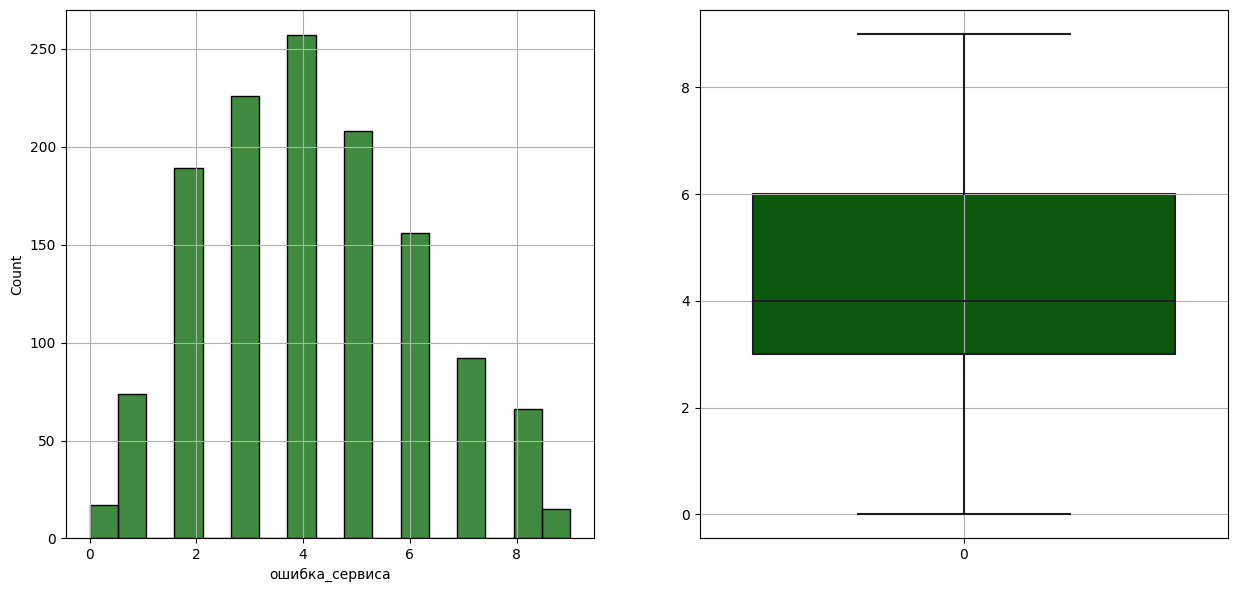

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64

Графики распределения количественного признака "страниц_за_визит"


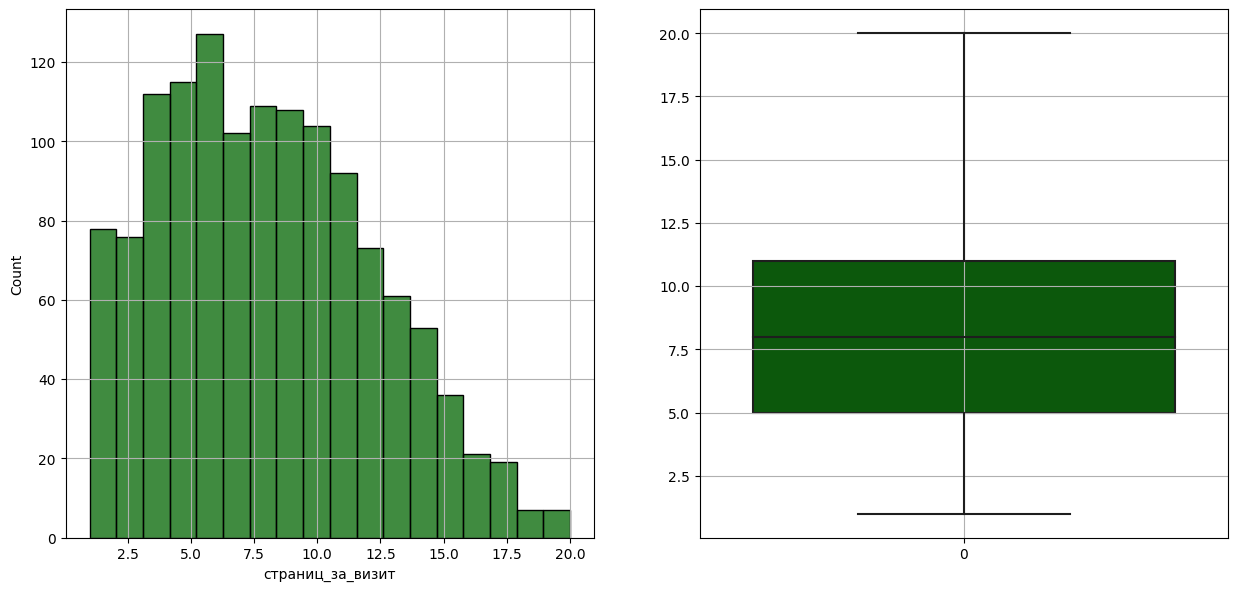

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64



In [14]:
for column in df_market_file.drop('id', axis=1).select_dtypes(include=np.number).columns.to_list():
    distribution_plots(df_market_file, column)

График распределения категориального признака "покупательская_активность"

Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64


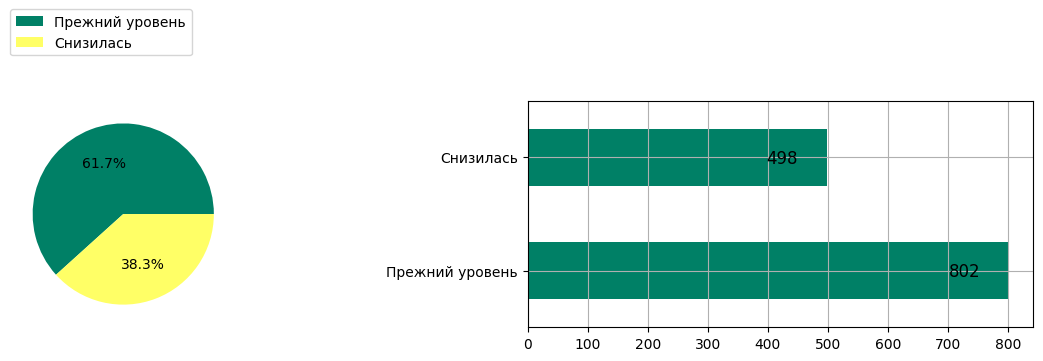


График распределения категориального признака "тип_сервиса"

стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64


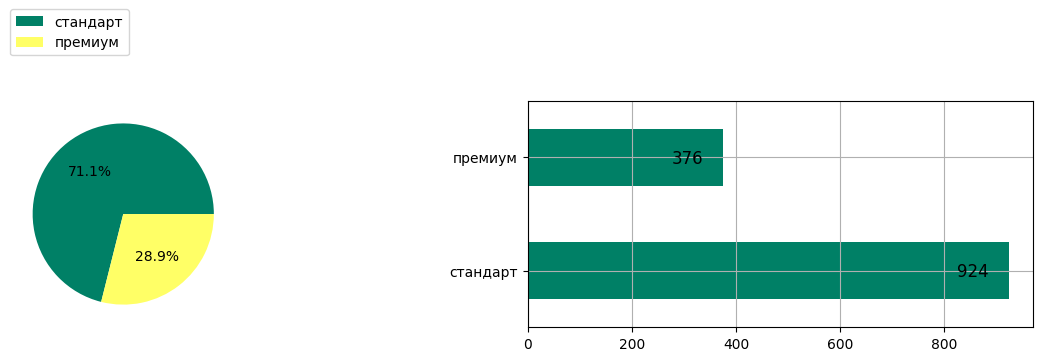


График распределения категориального признака "разрешить_сообщать"

да     962
нет    338
Name: разрешить_сообщать, dtype: int64


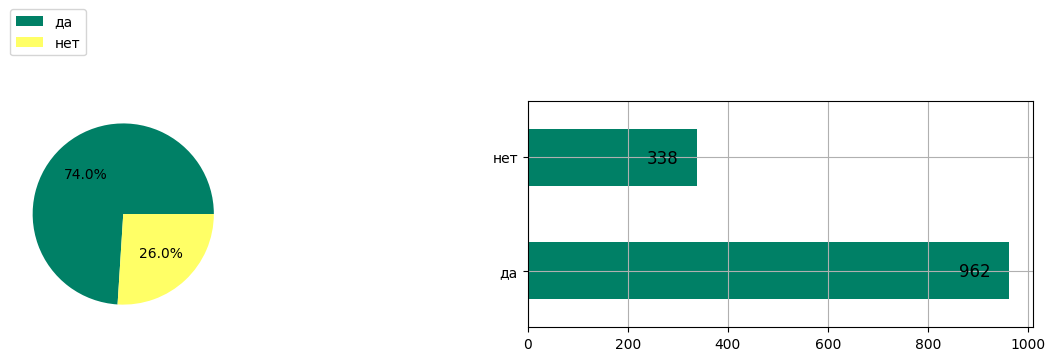


График распределения категориального признака "популярная_категория"

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64


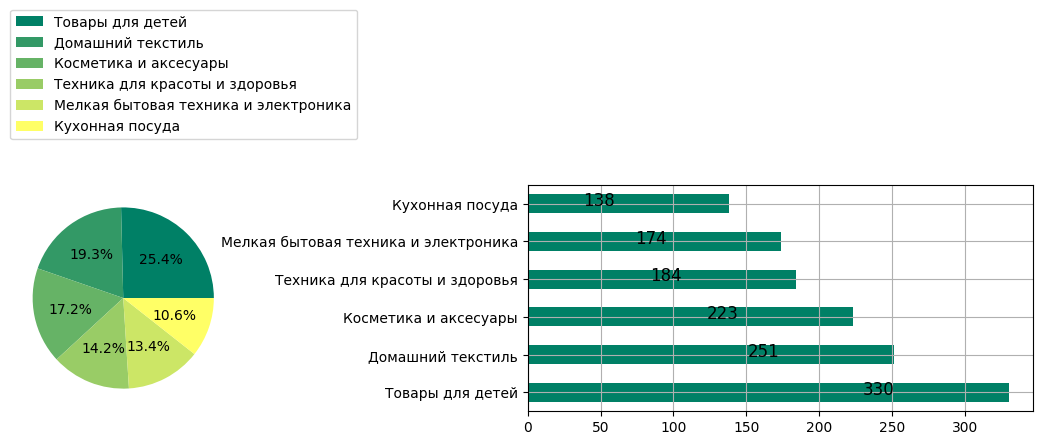

In [15]:
for column in df_market_file.select_dtypes(exclude=np.number).columns.to_list():
    categotial_plots(df_market_file,column)

**Промежуточные выводы:**

 - распределение количественного признака "маркет_актив_6_мес" нормальное с локальными пиками(небольшими), есть незначительные выбросы;
 - распределение количественного признака "маркет_актив_тек_мес" мультимодальное, три пика: 3.0, 4.0 и 5.0;
 - распределение количественного признака "длительность" нормальное, выбросов не наблюдается;
 - распределение количественного признака "акционные_покупки" бимодальное - два пика 0.3 и 0.95(часть клиентов склонна к исключительно акционным покупкам);
 - распределение количественного признака "средний_просмотр_категорий_за_визит" нормальное, без выбросов;
 - распределение количественного признака "неоплаченные_продукты_штук_квартал" нормальное, с ассиметрией, есть незначительные выбросы;
 - распределение количественного признака "ошибка_сервиса" нормальное, без выбросов;
 - распределение количественного признака "страниц_за_визит" нормальное, без выбросов.

### Исследовательский анализ данных для df_market_money

Графики распределения количественного признака "выручка"


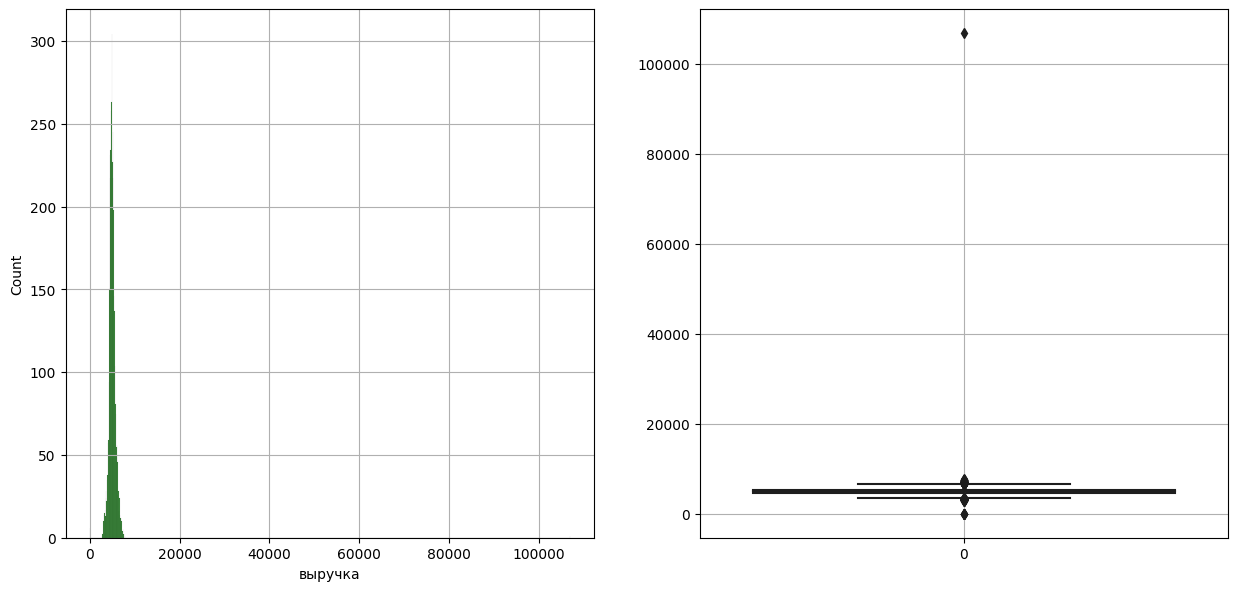

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64



In [16]:
distribution_plots(df_market_money, 'выручка')

Графики распределения количественного признака "выручка"


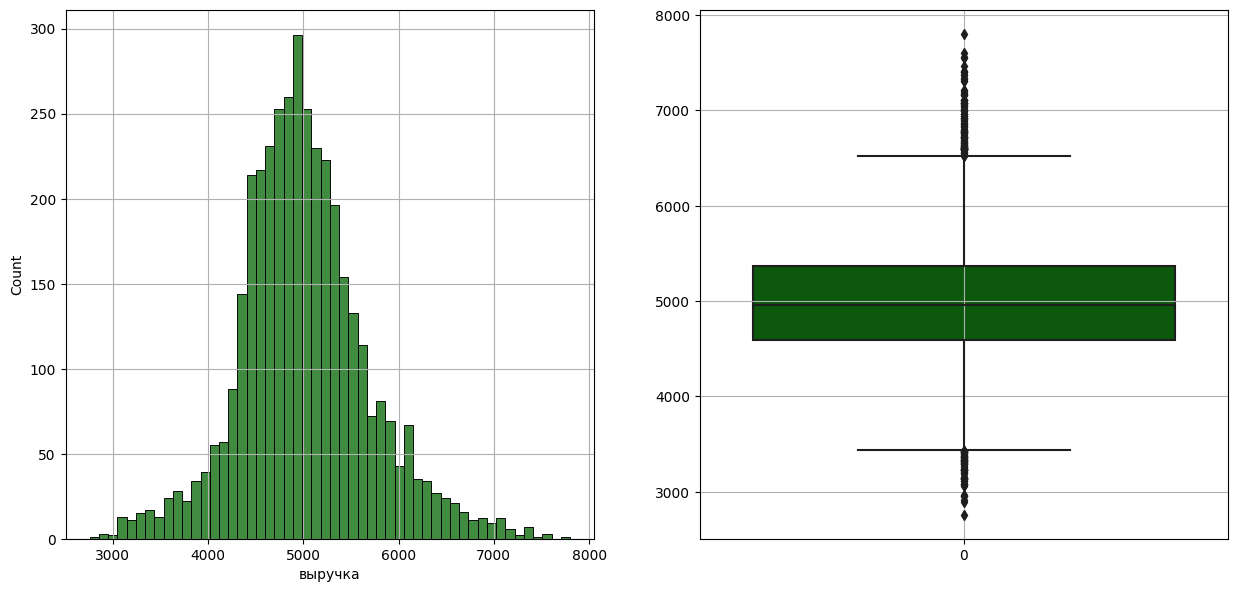

count    3893.000000
mean     5007.282918
std       679.724898
min      2758.700000
25%      4592.000000
50%      4959.000000
75%      5363.000000
max      7799.400000
Name: выручка, dtype: float64



In [17]:
#создаем новый датафрейм, очищенный от выбросов
df_market_money_clean=df_market_money.query('0 < выручка < 106862.2').reset_index(drop=True)
distribution_plots(df_market_money_clean, 'выручка')

График распределения категориального признака "популярная_категория"

текущий_месяц          1299
предыдущий_месяц       1297
препредыдущий_месяц    1297
Name: период, dtype: int64


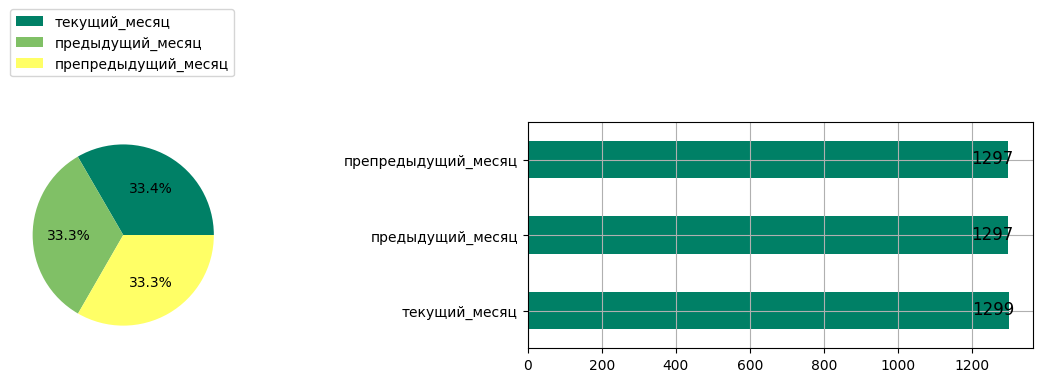

In [18]:
categotial_plots(df_market_money_clean, 'период')

**Промежуточные выводы:**
 - после устранения крупных выбросов распределение похоже на нормальное, осталась часть незначительных выбросов.

### Исследовательский анализ данных для df_market_time

Графики распределения количественного признака "минут"


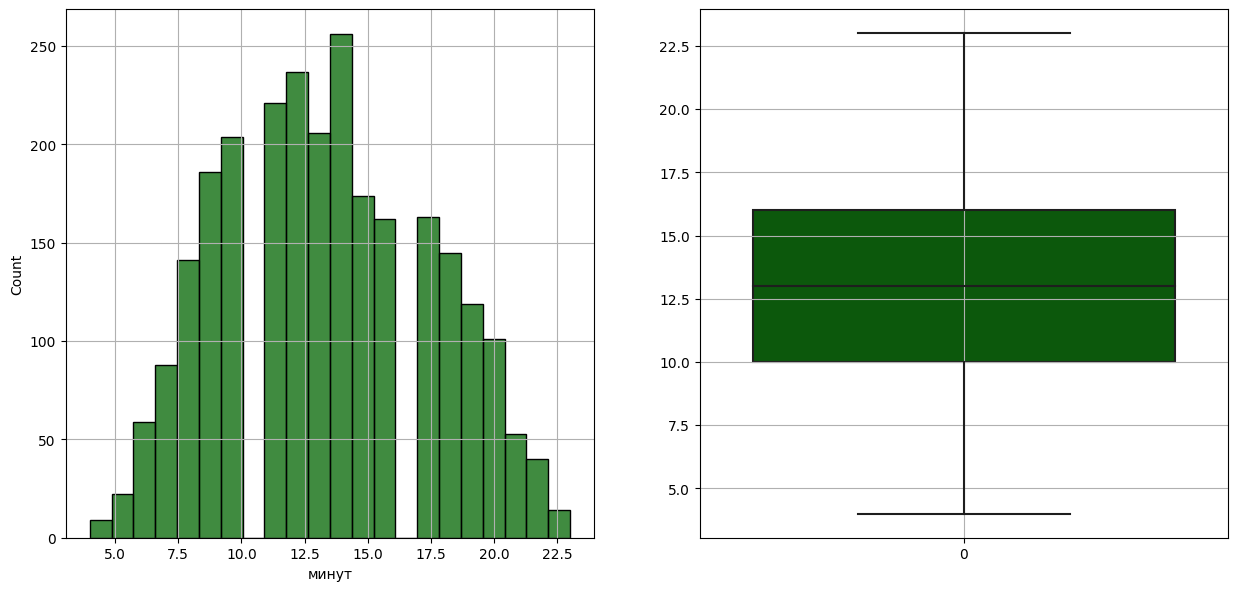

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64



In [19]:
distribution_plots(df_market_time, 'минут')

График распределения категориального признака "популярная_категория"

текущий_месяц       1300
предыдущий_месяц    1300
Name: период, dtype: int64


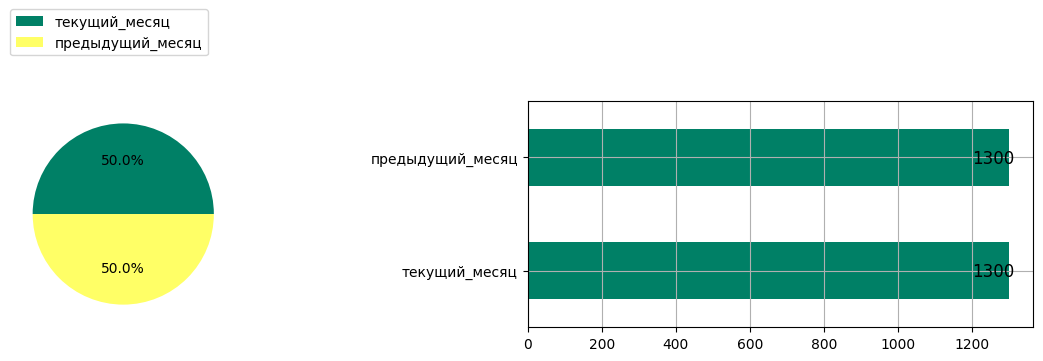

In [20]:
categotial_plots(df_market_time, 'период')

**Промежуточные выводы:**
 - нормальное распределение, нет выбросов.
 

### Исследовательский анализ данных для df_money

Графики распределения количественного признака "прибыль"


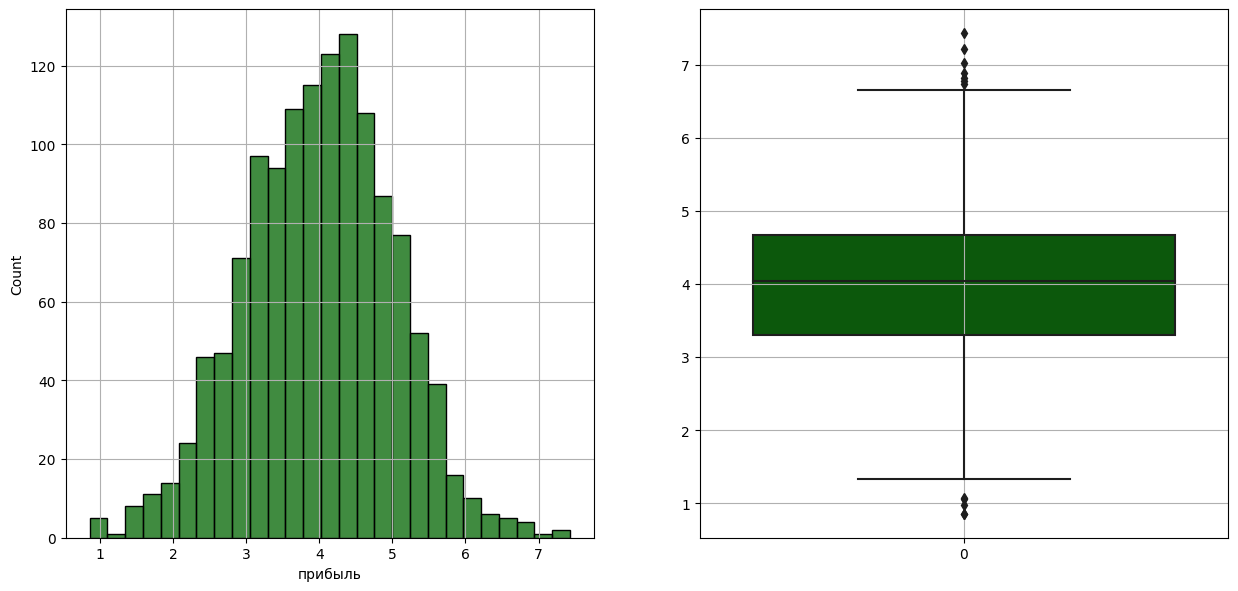

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64



In [21]:
distribution_plots(df_money, 'прибыль')

**Промежуточные выводы:**
 - нормальное распределение, есть незначительное количество выбросов.

### Исключение лишних данных

В соответстствии с условиями исследования исключим из исследования клиентов, которые не являются поcтоянными, т.е не совершают покупки ежемесячно. Так же исключим клиентов,совершивших аномально крупные покупки, так как подобные данные негативно отразятся в дальнейшем на качестве модели.

In [22]:
print(df_market_money.query('выручка==0'))
print()
ignore_list = list(df_market_money.query('выручка==0')['id'].unique())
print(f'Список id клиентов не совершающих покупки ежемесячно:  {ignore_list}')

ignore_list.extend(df_market_money[df_market_money['выручка']==106862.2]['id'].to_list())

print(f'Список id клиентов не совершающих покупки ежемесячно или совершивших слишком крупную покупку(подозрительные выбросы):  {ignore_list}')

        id               период  выручка
0   215348  препредыдущий_месяц      0.0
2   215348     предыдущий_месяц      0.0
28  215357  препредыдущий_месяц      0.0
29  215357     предыдущий_месяц      0.0
34  215359     предыдущий_месяц      0.0
35  215359  препредыдущий_месяц      0.0

Список id клиентов не совершающих покупки ежемесячно:  [215348, 215357, 215359]
Список id клиентов не совершающих покупки ежемесячно или совершивших слишком крупную покупку(подозрительные выбросы):  [215348, 215357, 215359, 215380]


In [23]:
df_market_money=df_market_money.query('id != @ignore_list')
df_market_money.nunique()

id         1296
период        3
выручка    2771
dtype: int64

### Объединение данных

Для более коротких названий введем уловное обозначение месяцев как:
- "препредыдущий_месяц"="03_мес",
- "предыдущий_месяц"="02_мес",
- "текущий_месяц"="01_мес".

In [24]:
df_market_united=(df_market_file.merge(
                  df_market_money.query('период=="препредыдущий_месяц"')[['id','выручка']], on='id')
                  .rename(columns={'выручка': 'выручка_за_03_мес'})
                  .reset_index(drop=True))
df_market_united=(df_market_united.merge(
                  df_market_money.query('период=="предыдущий_месяц"')[['id','выручка']], on='id')
                  .rename(columns={'выручка': 'выручка_за_02_мес'})
                  .reset_index(drop=True))
df_market_united=(df_market_united.merge(
                  df_market_money.query('период=="текущий_месяц"')[['id','выручка']], on='id')
                  .rename(columns={'выручка': 'выручка_за_01_мес'})
                  .reset_index(drop=True))
df_market_united=(df_market_united.merge(
                  df_market_time.query('период=="предыдущий_месяц"')[['id','минут']], on='id')
                  .rename(columns={'минут': 'минут_за_02_мес'})
                  .reset_index(drop=True))
df_market_united=(df_market_united.merge(
                  df_market_time.query('период=="текущий_месяц"')[['id','минут']], on='id')
                  .rename(columns={'минут': 'минут_за_01_мес'})
                  .reset_index(drop=True))

In [25]:
df_market_united.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_03_мес,выручка_за_02_мес,выручка_за_01_мес,минут_за_02_мес,минут_за_01_мес
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10


In [26]:
print(df_market_united.shape)
df_market_united.info()

(1296, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса     

## Корреляционный анализ

Построим, визуализируем и изучим матрицу корелляции при помощи библиотеки phik.

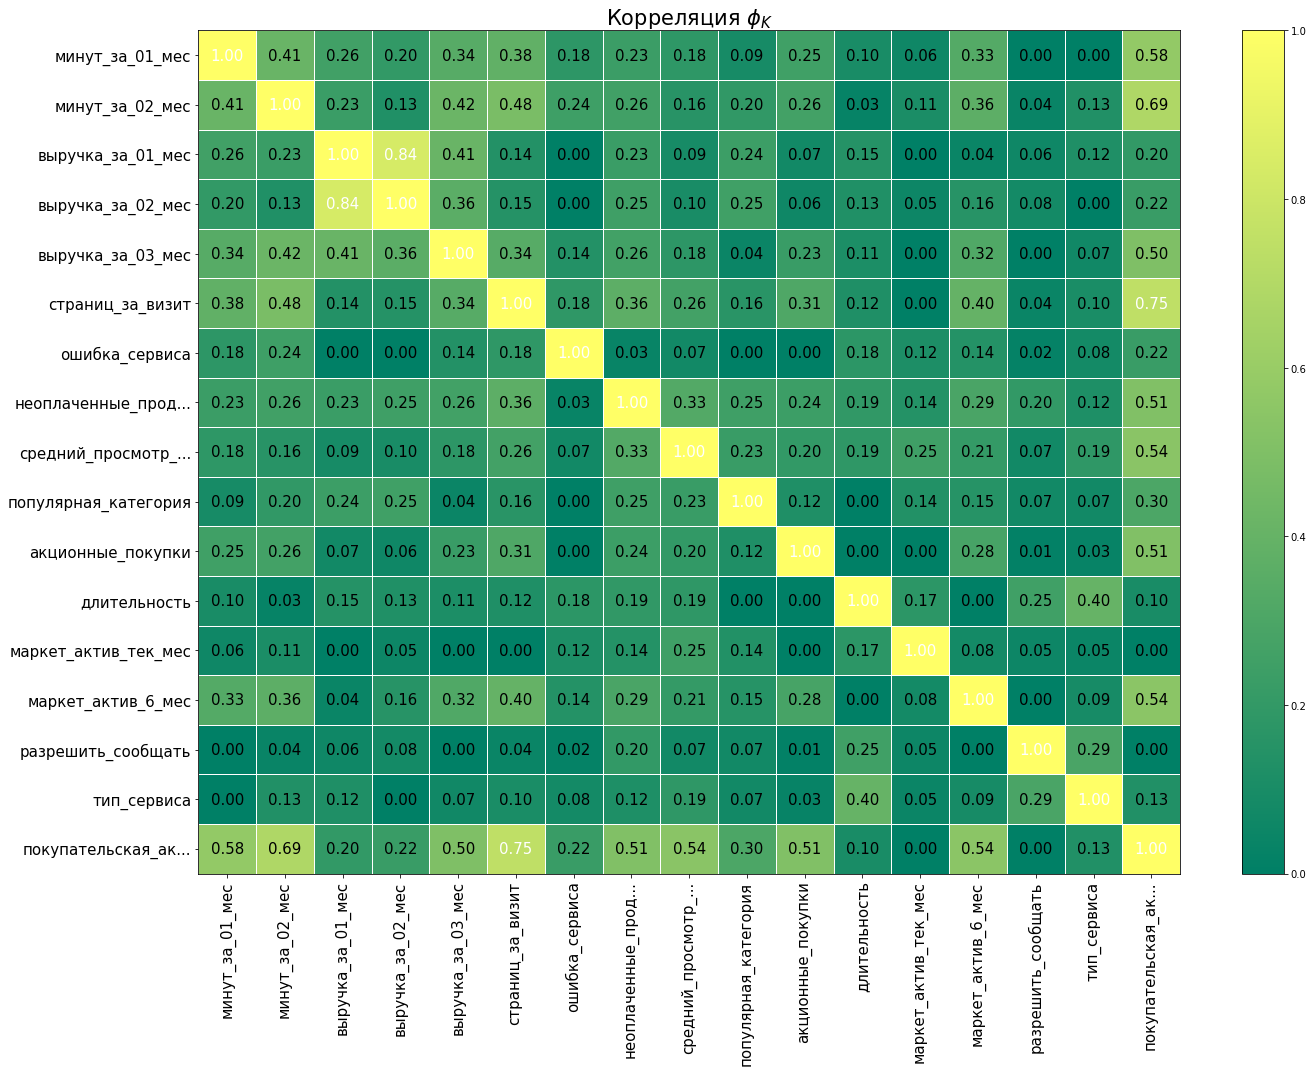

In [27]:
phik_overview = (
    df_market_united
    .drop('id', axis=1)
    .phik_matrix(verbose=False))

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='summer',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

О мультиколлинеарности свидетельствует значение коэффициента корреляции от 0.9 до 0.95 по модулю, в данном случае мультиколлинеарность отсутствует.
Самая значимая взаимосвязь между входными признаками выражена значением - 0.84 - между 'выручка_за_02_мес' и 'выручка_за_01_мес  '.

Наиболее значимые взимосвязи видим между целевы признаком 'покупательская активность' и входными признаками:
- 'страниц за визит' - 0.75;
- 'минут_за_02_мес' - 0.69.

Так же заметная взиимосвязь с целевым признаком наблюдается у входных признаков:
- 'минут_за_01_мес' - 0.58;
- 'средний_просмотр_категорий_за_визит', 'маркет_актив_6_мес ' - 0.54;
- 'неоплаченные_продукты_штук_квартал', 'акционные_покупки' - 0.51.

## Использование пайплайнов

Преобразуем целевой признак покупательская_активность - изменим категориальные значения 'Снизилась' и 'Прежний уровень' на 1 и 0.

In [28]:
df_market_united['покупательская_активность'].value_counts()


Прежний уровень    802
Снизилась          494
Name: покупательская_активность, dtype: int64

In [29]:
map_dict = {'Снизилась' : 1,
            'Прежний уровень' : 0,}

df_market_united['покупательская_активность'] = df_market_united['покупательская_активность'].map(map_dict)


In [30]:
df_market_united['покупательская_активность'].value_counts()

0    802
1    494
Name: покупательская_активность, dtype: int64

### Подготовка данных для построения моделей

При исследовательском анализе данных нами было обнаружено, что соотношение классов во вхоодном признаке 'покупательская активность' непропорционально. 
- 'Снизилась'(1) - 38.3%
- 'Прежний уровень'(0) - 61.7%

В связи с этим для сохранения баланса классов в выборках используем стратификацию.

In [31]:
# выделяем в отдельные переменные целевой признак и входные признаки
X = df_market_united.drop(columns=['покупательская_активность', 'id'])
y = df_market_united['покупательская_активность']

# разбиваем данные на выборки с учётом стратификации по целевому признаку
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE, 
    test_size=TEST_SIZE, 
    stratify=y
) 


Проверим успешность стратификации визуализацией процентного соотношения классов в исходных данных и выборках.

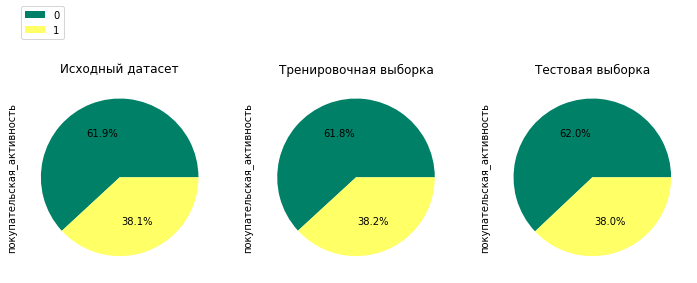

In [32]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
y.value_counts().plot(kind='pie', ax=axes[0], autopct='%.1f%%', labels=['', ''], colormap='summer')
axes[0].set_title("Исходный датасет")
y_train.value_counts().plot(kind='pie', ax=axes[1], autopct='%.1f%%', labels=['', ''], colormap='summer')
axes[1].set_title("Тренировочная выборка")
y_test.value_counts().plot(kind='pie', ax=axes[2], autopct='%.1f%%', labels=['', ''], colormap='summer')
axes[2].set_title("Тестовая выборка")

axes[0].legend(loc=(0, 1.2), labels=y.value_counts().index)

plt.show()

### Создание пайплайнов

Создадим пайплайн, который выберет лучшую комбинацию модели и гиперпараметров.
Используем модели:

 - DecisionTreeClassifier() с гиперпараметрами max_depth от 2 до 5 включительно, max_features от 2 до 5 включительно;
 
 - KNeighborsClassifier() с гиперпараметром n_neighbors от 2 до 5 включительно;
 
 - LogisticRegression(solver='liblinear', penalty='l1') с гиперпараметром регуляризации С от 1 до 5 включительно;
 
 - SVC(kernel='poly') с гиперпараметром degree от 1 до 10 включительно.

Рассчитаем метрику ROC-AUC на тренировочной и тестовой выборках для лучшей модели, так как данная метрика лучше всего подойдёт для задачи бинарной классификации с несбалансированным целевым признаком.

In [33]:
# создаём списки с названиями признаков 
num_columns = ['маркет_актив_6_мес', 
               'маркет_актив_тек_мес', 
               'длительность', 
               'акционные_покупки', 
               'средний_просмотр_категорий_за_визит', 
               'неоплаченные_продукты_штук_квартал', 
               'ошибка_сервиса', 
               'страниц_за_визит', 
               'выручка_за_03_мес', 
               'выручка_за_02_мес',
               'выручка_за_01_мес', 
               'минут_за_02_мес', 
               'минут_за_01_мес']

ohe_columns = ['популярная_категория']

ord_columns = ['тип_сервиса', 'разрешить_сообщать']

In [34]:
# создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))])

# создаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [('ord', OrdinalEncoder(
    categories=[
        ['стандарт', 'премиум'], 
        ['да', 'нет']
    ], 
    handle_unknown='use_encoded_value', 
    unknown_value=np.nan))
                    ]
                   )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [35]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(kernel = 'poly',random_state=RANDOM_STATE, probability= True)],
        'models__degree': range(1,11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  

    },
    
]

In [36]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)


randomized_search.fit(X_train, y_train)
# y_test_pred = randomized_search.predict(X_test)
probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]


print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print()
print()
print(f'Параметры лучшей модели:\n{randomized_search.best_params_}')
print()
print()
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
print()
print()
# print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум'],
                                                                                              ['да',
                    

In [37]:
#получим все результаты и сделаем из них датафрейм. 
#Выведем четыре столбца, отсортируем по rank_test_score — рейтингу качества моделей
pd.DataFrame(randomized_search.cv_results_)[
    ['std_test_score', 'rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,std_test_score,rank_test_score,param_models,mean_test_score,params
2,0.016742,1,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.896593,"{'preprocessor__num': MinMaxScaler(), 'models__C': 2, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"
1,0.017218,2,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.896105,"{'preprocessor__num': RobustScaler(), 'models__C': 2, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"
3,0.014542,3,KNeighborsClassifier(),0.870353,"{'preprocessor__num': RobustScaler(), 'models__n_neighbors': 3, 'models': KNeighborsClassifier()}"
5,0.015063,4,"SVC(kernel='poly', probability=True, random_state=42)",0.855693,"{'preprocessor__num': MinMaxScaler(), 'models__degree': 7, 'models': SVC(kernel='poly', probability=True, random_state=42)}"
4,0.033510,5,DecisionTreeClassifier(random_state=42),0.831939,"{'preprocessor__num': StandardScaler(), 'models__max_features': 5, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
7,0.033510,5,DecisionTreeClassifier(random_state=42),0.831939,"{'preprocessor__num': RobustScaler(), 'models__max_features': 5, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
0,0.014602,7,DecisionTreeClassifier(random_state=42),0.813008,"{'preprocessor__num': StandardScaler(), 'models__max_features': 4, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}"
6,0.036269,8,"SVC(kernel='poly', probability=True, random_state=42)",0.803055,"{'preprocessor__num': RobustScaler(), 'models__degree': 10, 'models': SVC(kernel='poly', probability=True, random_state=42)}"
8,0.019826,9,DecisionTreeClassifier(random_state=42),0.773156,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 5, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"
9,0.028607,10,DecisionTreeClassifier(random_state=42),0.728088,"{'preprocessor__num': StandardScaler(), 'models__max_features': 2, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"


Вывод по использованию пайплайнов:
Построили пайплайн и нашли лучшую комбинацию модели и гиперпараметров:

 - LogisticRegression с параметром solver='liblinear' и лассо-регуляризацией;
 - гиперпараметр C=2;
 - скалером MinMaxScaler()
 
Площадь ROC-кривой на тестовой выборке: 0.91
 
Метрика ROC-AUC лучшей модели на тренировочной выборке: 0.892

## Анализ важности признаков

In [ ]:
# кодируем категориальные признаки с помощью OneHotEncoder()
ohe_encoder = OneHotEncoder(sparse_output=False, drop='first')
X_train_ohe = ohe_encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = ohe_encoder.transform(X_test[ohe_columns])
ohe_encoder_col_names = ohe_encoder.get_feature_names_out()

# кодируем категориальные признаки с помощью OrdinalEncoder()
ord_encoder = OrdinalEncoder()
X_train_ord = ord_encoder.fit_transform(X_train[ord_columns])
X_test_ord = ord_encoder.transform(X_test[ord_columns])
ord_encoder_col_names = ord_encoder.get_feature_names_out()

# масштабируем количественные признаки с помощью RobustScaler()
scaler =  MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_encoder_col_names)

X_train_ord = pd.DataFrame(X_train_ord, columns=ord_encoder_col_names)
X_test_ord = pd.DataFrame(X_test_ord, columns=ord_encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
X_train_first = pd.concat([X_train_ohe, X_train_ord], axis=1)
X_train_final = pd.concat([X_train_first, X_train_scaled], axis=1)

X_test_first = pd.concat([X_test_ohe, X_test_ord], axis=1)
X_test_final = pd.concat([X_test_first, X_test_scaled], axis=1)

In [ ]:
# объявляем классификатор и обучаем модель
clf_best = LogisticRegression(solver='liblinear', 
                             penalty='l1',
                             C=2, 
                             random_state=RANDOM_STATE)
clf_best.fit(X_train_final, y_train)
y_pred = clf_best.predict(X_test_final)

# в отдельную переменную сохраняем предсказания принадлежности к классам для тестовых данных
clf_best_probas = clf_best.predict_proba(X_test_final)[:,1]

# считаем метрику ROC-AUC для тренировочных и тестовых данных
print('Метрики Best Model:')
roc_auc_cv = cross_val_score(clf_best, X_train_final, y_train, scoring='roc_auc').mean()
print(f'ROC-AUC на тренировочной выборке: {round(roc_auc_cv, 3)}')
print(f'ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_pred), 3)}')

# оценка качества модели по метрике accuracy
clf_best_acc = accuracy_score(y_test, y_pred)
print('Accuracy:', round(clf_best_acc, 3))

# выводим F1-меру
clf_best_f1 = f1_score(y_test, y_pred, pos_label=1)
print('F1-score:', round(clf_best_f1, 3))

In [40]:
# создание и обучение модели DummyClassifier 
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train_final, y_train)

# предсказание на тестовых данных
dummy_model_preds = dummy_model.predict(X_test_final)

# считаем метрику ROC-AUC для тренировочных и тестовых данных
print('Метрики Dummy Model:')
d_roc_auc_cv = cross_val_score(dummy_model, X_train_final, y_train, scoring='roc_auc').mean()
print(f'ROC-AUC на тренировочной выборке: {round(d_roc_auc_cv, 3)}')

# оценка качества модели по метрике ROC-AUC
dummy_roc = roc_auc_score(y_test, dummy_model_preds)
print('ROC-AUC на тестовой выборке:', round(dummy_roc,2))

# оценка качества модели по метрике accuracy
dummy_acc = accuracy_score(y_test, dummy_model_preds)
print('Accuracy:', round(dummy_acc, 2))

# выводим F1-меру
dummy_f1 = f1_score(y_test, dummy_model_preds, pos_label=1)
print('F1-score:', round(dummy_f1,2))

Метрики Dummy Model:
ROC-AUC на тренировочной выборке: 0.5
ROC-AUC на тестовой выборке: 0.5
Accuracy: 0.62
F1-score: 0.0


**Промежуточные выводы:**
    
Результаты лучшей модели лучше Dummy Model. Выбранная модель адекватна и эффективна.

Метрики лучшей модели:

- ROC-AUC на тренировочной выборке - 0.897
- ROC-AUC на тестовой выборке - 0.893
- F1-мера - 0.874

Accuracy не учитывает дисбаланс классов, поэтому ей можно пренебречь в данном случае.

In [41]:
print(clf_best)

LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear')


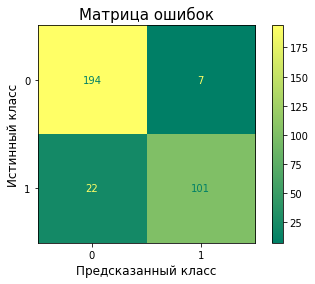

In [42]:
# построим матрицу ошибок для тестовых данных функцией ConfusionMatrixDisplay()
ConfusionMatrixDisplay.from_estimator(clf_best, X_test_final, y_test, cmap='summer')
plt.title('Матрица ошибок', size=15)
plt.xlabel('Предсказанный класс', size=12)
plt.ylabel('Истинный класс', size=12)
plt.show()

Модель предсказала:

 - верно класс 0 (Прежний уровень) - 194 раза;
 - верно класс 1 (Снизилась) - 101 раз;
 - ошибка False Negative - 22 раза;
 - ошибка False Positive - 7 раз;

Т.е. модель в 22 модель предсказывает, что покупатель не изменит своей активности, а активность на самом деле снизится, в 7 случаях наоборот, модель неверно предсказывает снижение у стабильных клиентов.

В целом ошибки не выглядят критично, проведем дальнейший анализ на текущей модели не меняя настроек.

## Анализ важности признаков

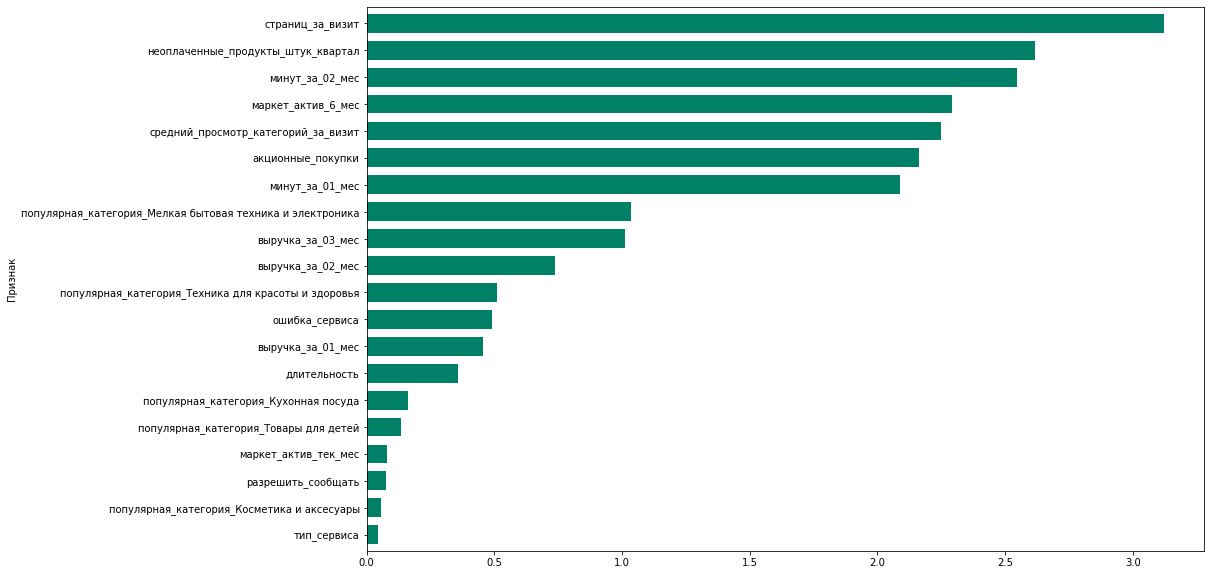

In [43]:
#Составим рейтинг признаков, которые вносят наибольший вклад в модель
coeffs = clf_best.coef_[0]
feature_importance = pd.DataFrame({'Признак': X_train_final.columns, 'Значимость': np.abs(coeffs)})
feature_importance = feature_importance.sort_values(by='Значимость', ascending=True)
feature_importance.plot(x='Признак', 
                        y='Значимость', 
                        kind='barh', 
                        figsize=(15, 10), 
                        cmap='summer', 
                        width=0.7,
                        legend='');

Исходя из графика признаки с наибольшим вкладом в модель это:

 - страниц за визит,
 - неоплаченные продукты(шт в квартал),
 - минут за предыдущий месяц,
 - мартек актив 6 мес,
 - средний просмотр категорий за визит,

 
 Наименьший вклад в модель вносят:
 - разрешение сообщать,
 - популярная категори якосметика и аксессуары,
 - тип сервиса.
 

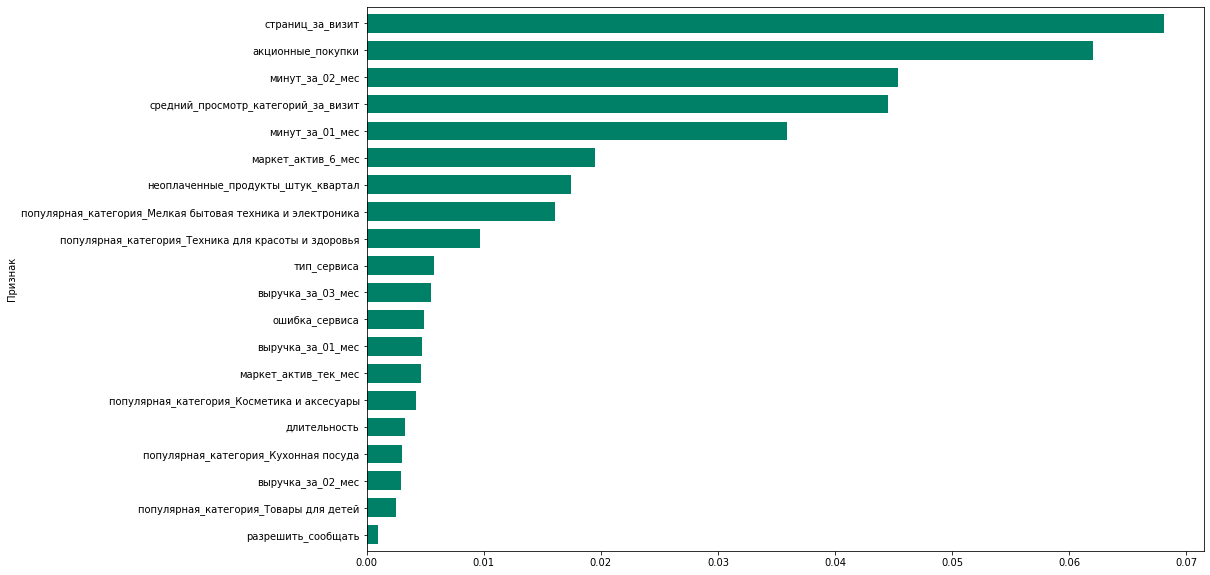

In [44]:
# выбираем новый селектор с нужными параметрами
# Проверка permutation importance с F1-мерой
selector_new = SelectKBest(f_classif, k='all')
X_new_new = selector_new.fit_transform(X_train_final, y_train)
features_names_new = X_train_final.columns[selector_new.get_support(indices=True)]

# функция расчёта оценки качества
def custom_f1(model, X, y):
    y_pred = model.predict(X)
    score = f1_score(y, y_pred)
    return score

result_new = permutation_importance(clf_best, X_test_final, y_test, scoring=custom_f1)

feature_importance_new = pd.DataFrame({'Признак': features_names_new, 'Значимость': result_new['importances_mean']})
feature_importance_new = feature_importance_new.sort_values('Значимость', ascending=True)
feature_importance_new.plot(x='Признак', 
                            y='Значимость', 
                            kind='barh', 
                            figsize=(15, 10), 
                            cmap='summer', 
                            width=0.7,
                            legend='');

Исходя из графика проверки permutation importance с F1-мерой признаки с наибольшим вкладом в модель это:
 - страниц за визит,
 - минут за предыдущий месяц,
 - акционные покупки,
 - средний просмотр категорий за визит,
 - минут за текущий месяц.
 
 Наименьший вклад в модель вносят:
 - разрешение сообщать,
 - популярная категори кухонная посуда,
 - длительность.

### Aнализ SHAP-значений

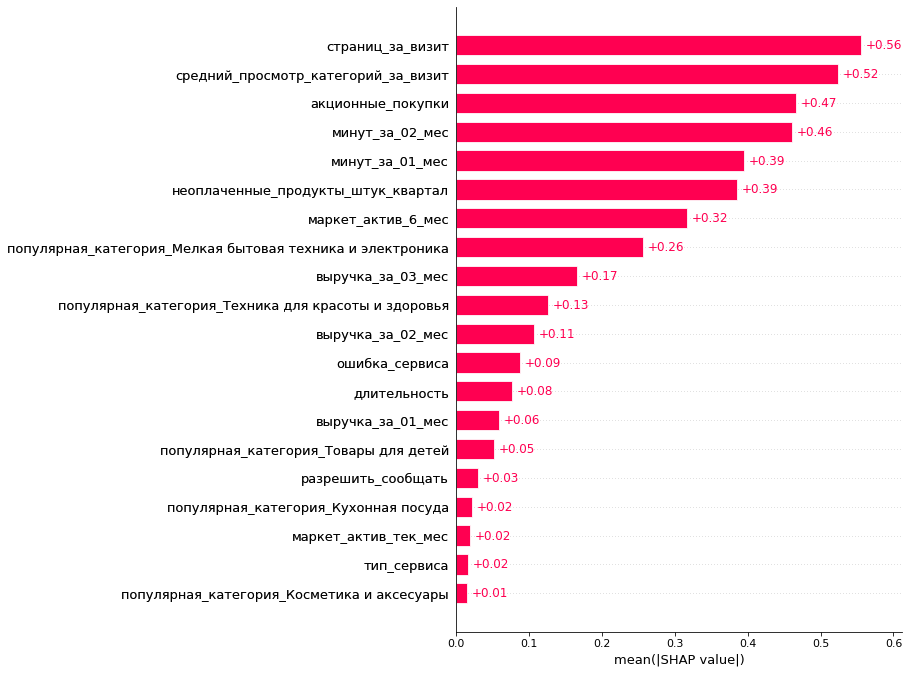

In [46]:
# строим график общей значимости признаков 
explainer = shap.LinearExplainer(clf_best, X_test_final)
shap_values = explainer(X_test_final)
shap.plots.bar(shap_values, max_display=21)

Лидирует по-прежнему просмотр страниц за визит, а вторым по значимости впервые стал — средний просмотр категорий за визит, раньше он был в пятерке самых важных из исходных признаков, но только сейчас он вошёл в тройку лучших.

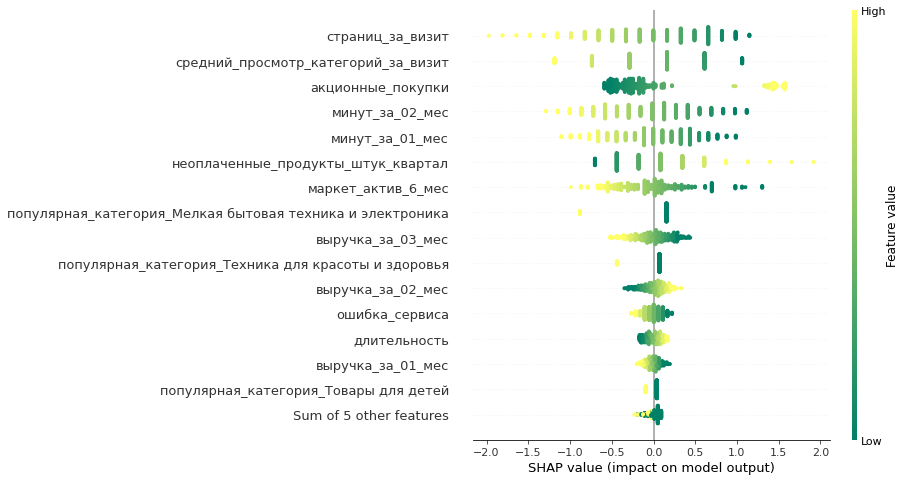

In [47]:
# визуализируем как признаки влияют на каждое предсказание модели
shap.plots.beeswarm(shap_values, max_display=16, color='summer') 

Исходя из графика можно сказать, что больше всех увеличивают вероятность принадлежности наблюдений к классу 1 признаки - акционные покупки и неоплаченные продукты(шт\квартал);
увеличивают вероятность принадлежности наблюдений к классу 0 признаки - страниц за визит и минут за предыдущий месяц.

In [48]:
# формируем столбцы
X_test_final['y_test'] = y_test.tolist()
X_test_final['y_pred'] = y_pred.tolist()
X_test_final['predict_proba'] = clf_best_probas

# выводим на экран неверно классифицированные классы 1
display(X_test_final[(X_test_final['y_test']==1)
                     & (X_test_final['y_pred']==0)
                     & (X_test_final['predict_proba']<=0.3)][['y_test', 
                                                            'y_pred',
                                                            'predict_proba',
                                                            'страниц_за_визит',
                                                            'средний_просмотр_категорий_за_визит',
                                                            'акционные_покупки']].sort_values(by='predict_proba'))

,y_test,y_pred,predict_proba,страниц_за_визит,средний_просмотр_категорий_за_визит,акционные_покупки
275,1,0,0.011766,0.631579,0.8,0.034091
111,1,0,0.028305,0.421053,1.0,0.068182
167,1,0,0.041728,0.631579,0.6,0.045455
272,1,0,0.042341,0.421053,0.4,0.034091
27,1,0,0.050914,0.842105,0.2,0.079545
201,1,0,0.079212,0.578947,0.6,0.056818
297,1,0,0.089943,0.789474,0.6,0.215909
24,1,0,0.096491,0.736842,0.4,0.147727
256,1,0,0.096968,0.315789,0.2,0.034091
314,1,0,0.104084,0.421053,0.4,0.113636


In [49]:
# выводим на экран неверно классифицированные классы 0 
display(X_test_final[(X_test_final['y_test']==0)
                     & (X_test_final['y_pred']==1)
                     & (X_test_final['predict_proba']>0.5)][['y_test', 
                                                            'y_pred', 
                                                            'predict_proba',
                                                            'страниц_за_визит',
                                                            'средний_просмотр_категорий_за_визит',
                                                            'акционные_покупки']].sort_values(ascending=False, 
                                                                                              by='predict_proba'))

,y_test,y_pred,predict_proba,страниц_за_визит,средний_просмотр_категорий_за_визит,акционные_покупки
216,0,1,0.638795,0.421053,0.4,0.909091
95,0,1,0.624417,0.157895,0.0,0.045455
277,0,1,0.604596,0.105263,0.4,0.136364
227,0,1,0.592756,0.631579,0.2,0.159091
142,0,1,0.566082,0.526316,0.0,0.215909
242,0,1,0.533896,0.473684,0.2,0.136364
239,0,1,0.524362,0.157895,0.2,0.159091


Индекс: 24


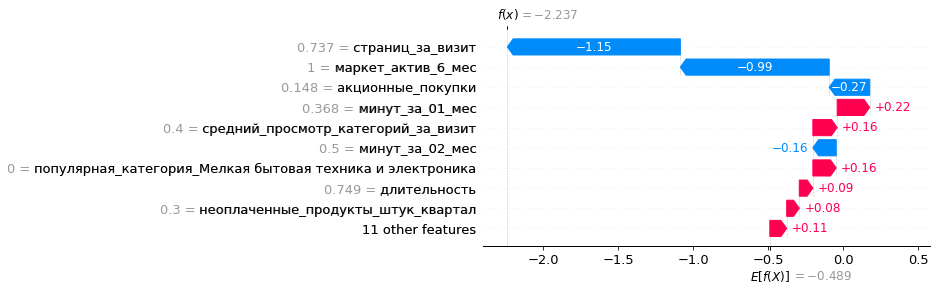


Индекс: 27


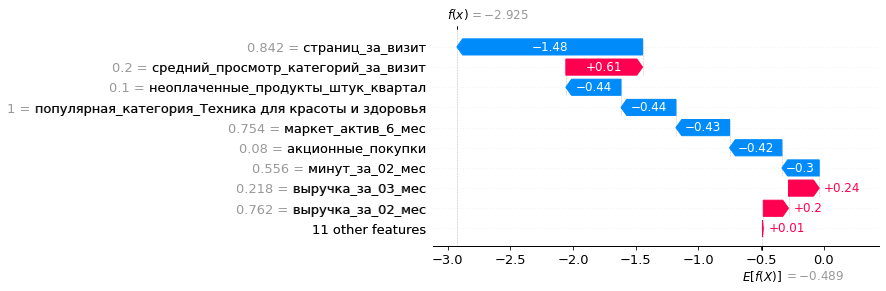


Индекс: 67


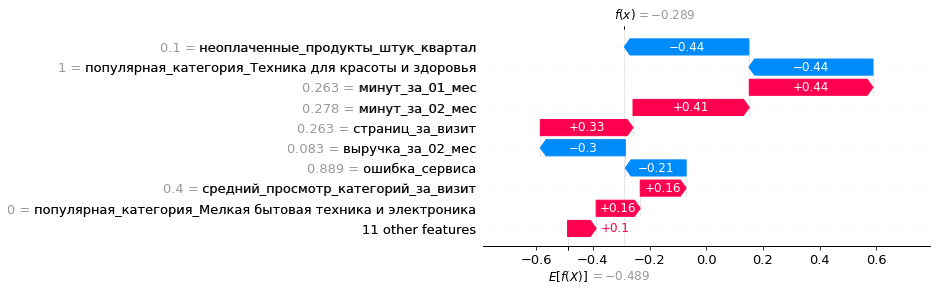


Индекс: 77


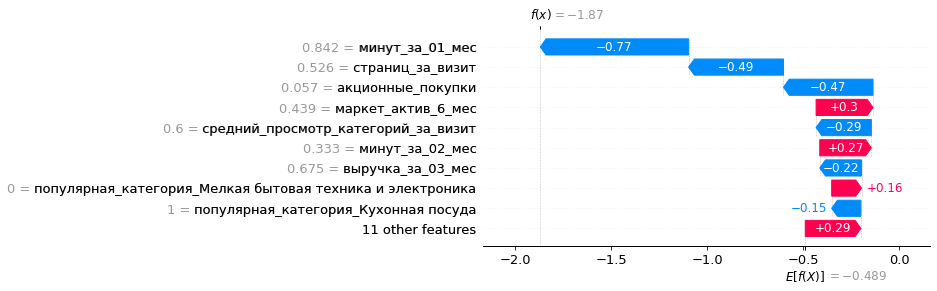


Индекс: 83


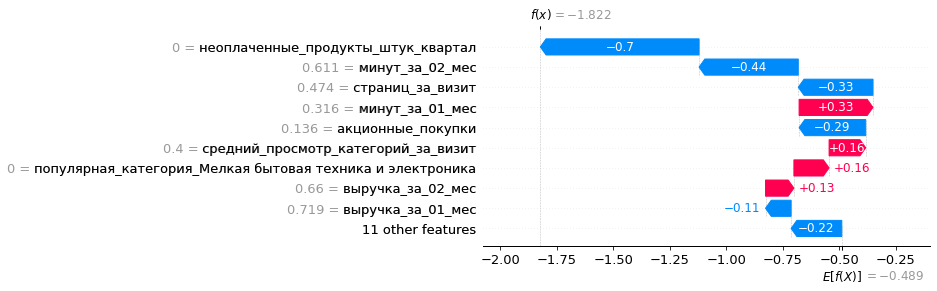


Индекс: 111


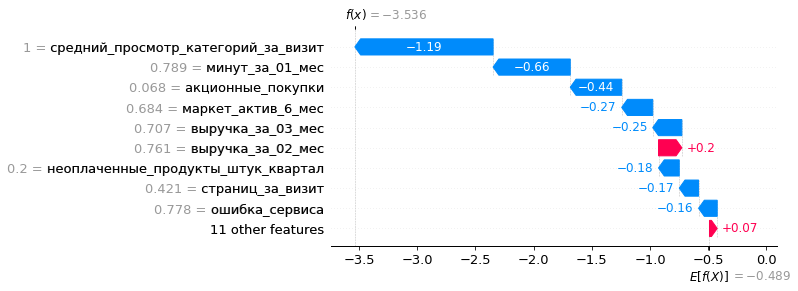


Индекс: 136


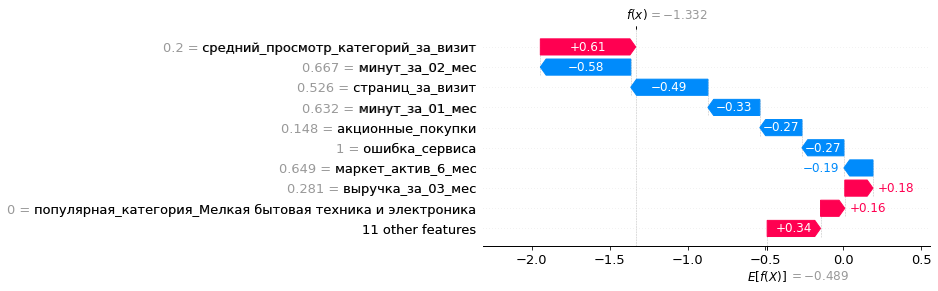


Индекс: 141


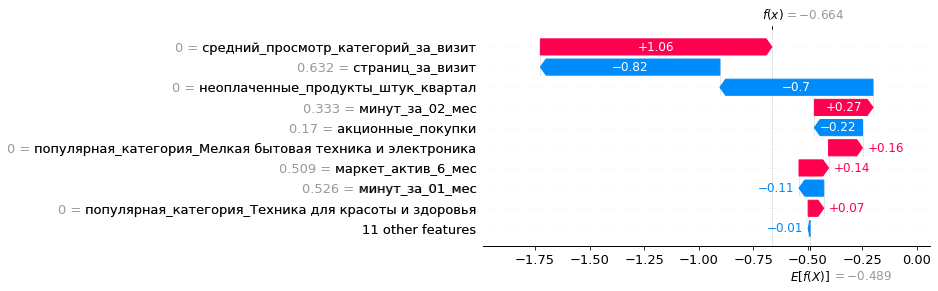


Индекс: 144


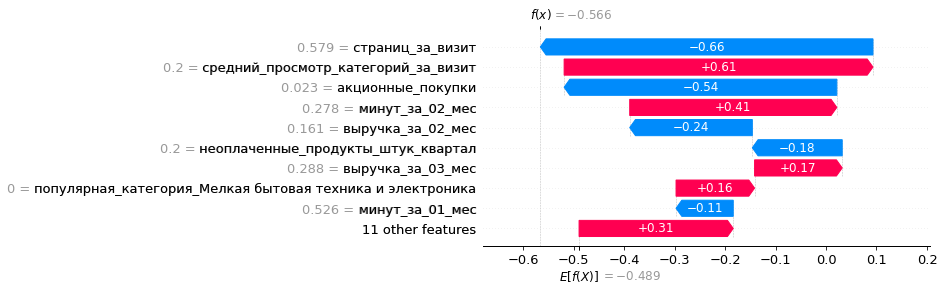


Индекс: 152


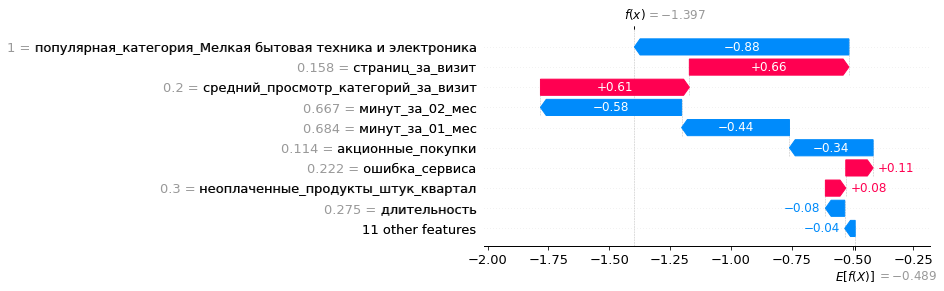


Индекс: 167


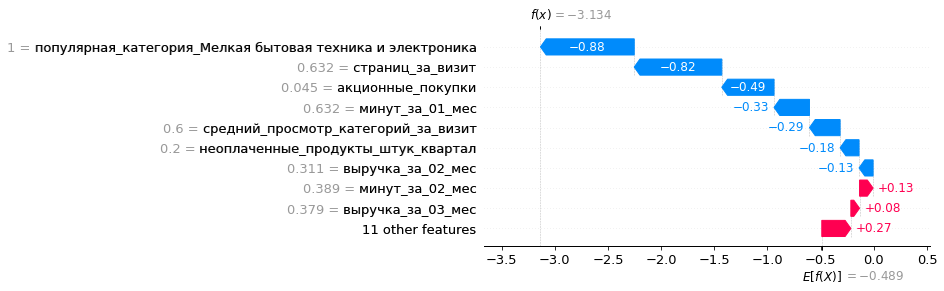


Индекс: 184


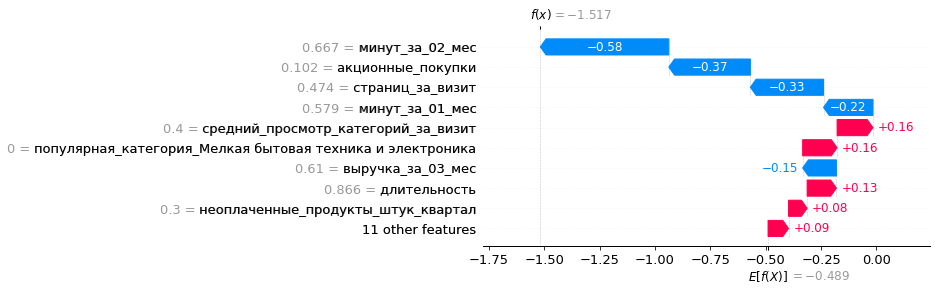


Индекс: 198


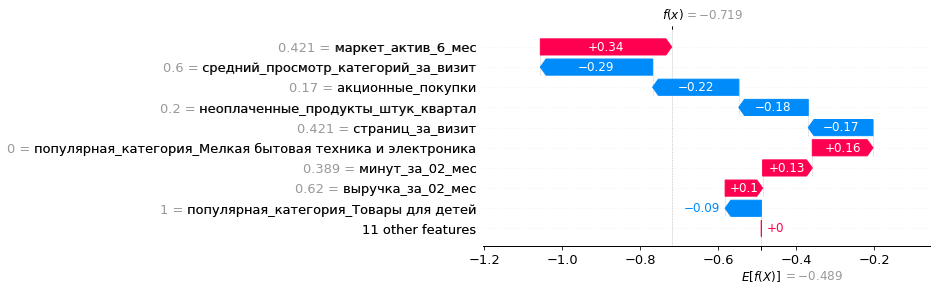


Индекс: 200


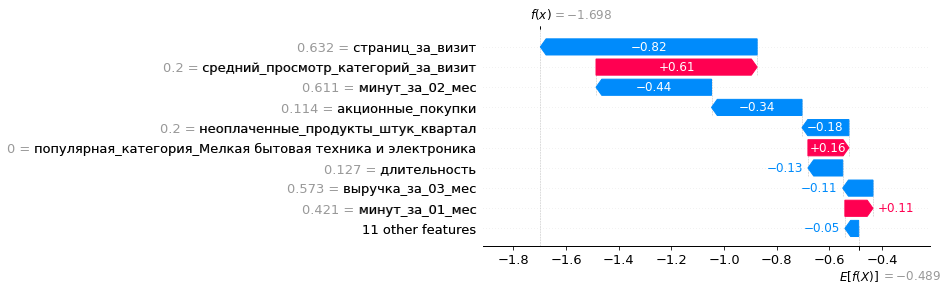


Индекс: 201


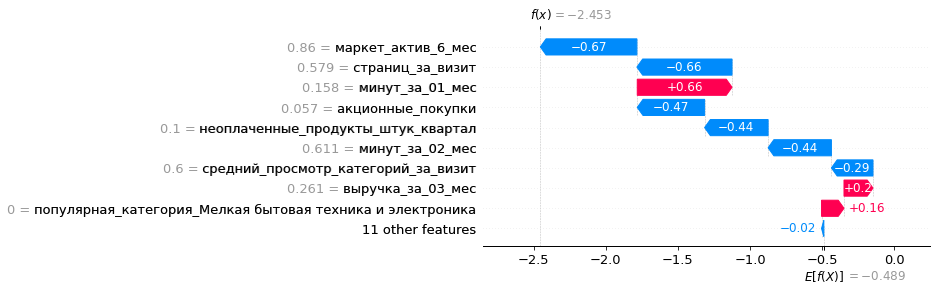


Индекс: 256


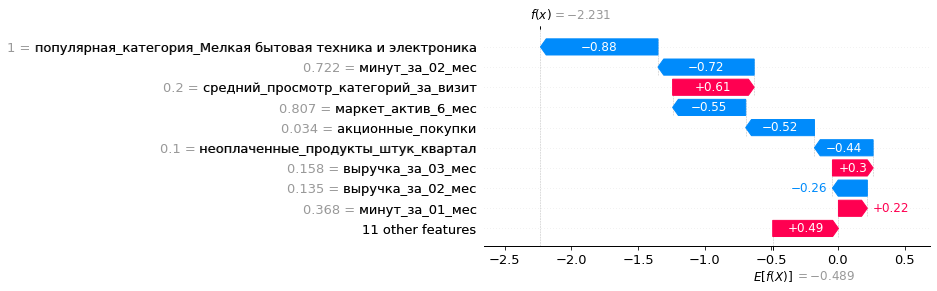


Индекс: 272


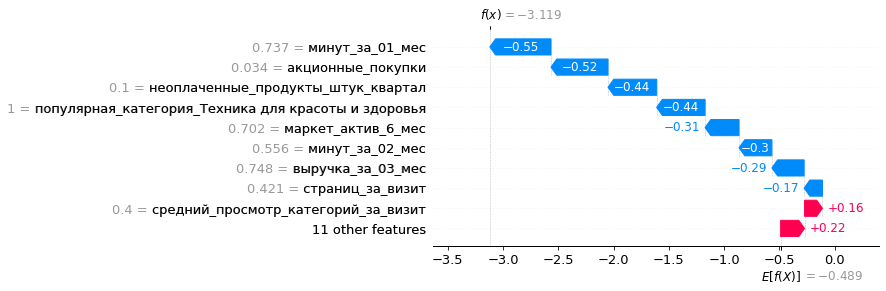


Индекс: 275


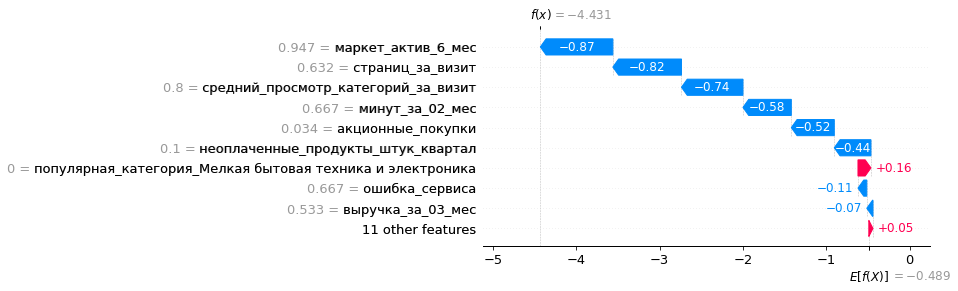


Индекс: 281


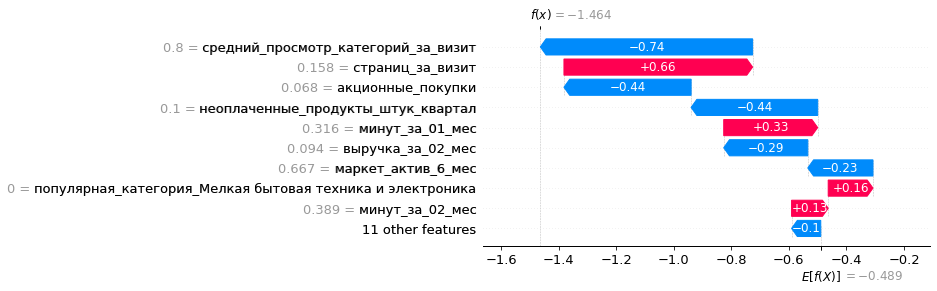


Индекс: 297


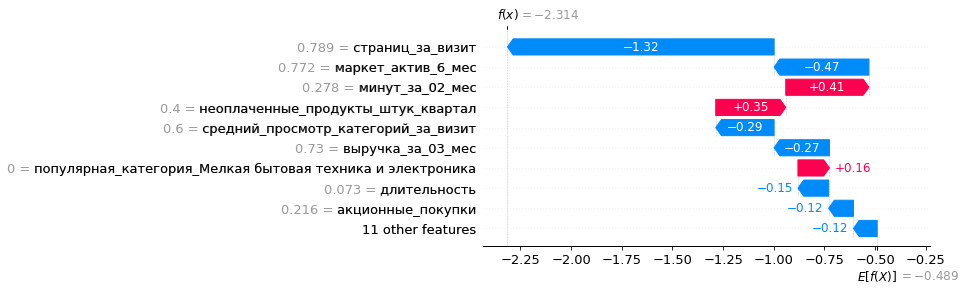


Индекс: 314


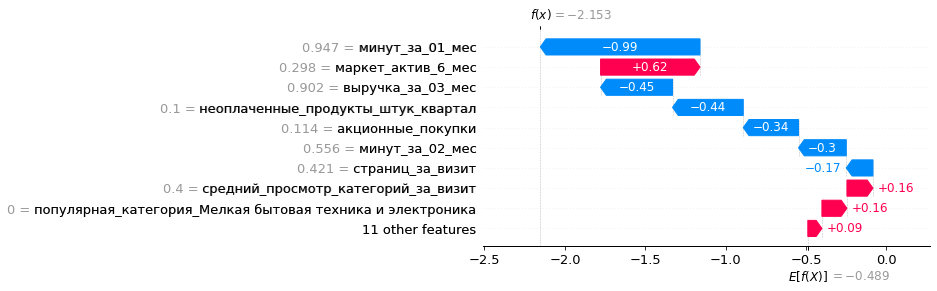


Индекс: 317


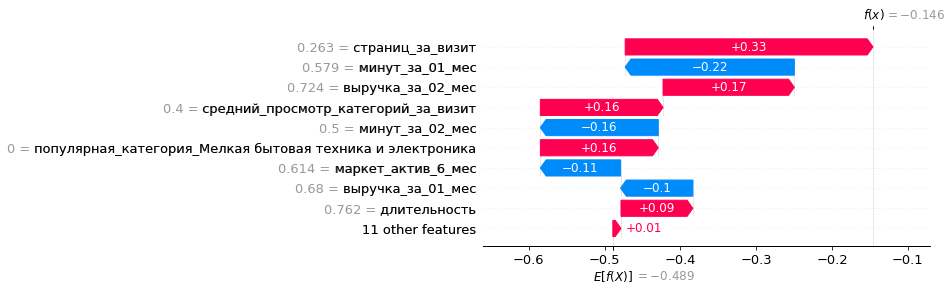

In [50]:
for i in X_test_final.index[(X_test_final['y_test']==1) & (X_test_final['y_pred']==0)].tolist():
    print('Индекс:', i)
    fig = plt.figure()
    shap.plots.waterfall(shap_values[i], show=False)
    plt.gcf().set_size_inches(8, 4)
    plt.show()
    print()

**Промежуточные выводы:**

    - сильнее всего вляют на целевой признак входные признаки:
        - 'минут_за_2_мес',
        - 'страниц_за_визит',
        - 'средний_просмотр_категорий_за_визит',
        - 'акционные покупки'.
    
        
    - самое слабое влияние показывают входные признаки:
        - 'популярная_категория_Косметика_и_аксессуары',
        - 'тип_сервиса',
        - 'маркет_актив_тек_мес'.

## Сегментация покупателей.

In [51]:
#собираем обратно тестовую выборку с вероятностями и прогнозами
train = pd.concat([X_train, y_train], axis=1)
train['вероятность']=clf_best.predict_proba(X_train_final)[:,1].tolist()
train['прогноз_покуп_активности'] = clf_best.predict(X_train_final).tolist()
train.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_03_мес,выручка_за_02_мес,выручка_за_01_мес,минут_за_02_мес,минут_за_01_мес,покупательская_активность,вероятность,прогноз_покуп_активности
506,стандарт,да,5.5,4,510,0.15,Мелкая бытовая техника и электроника,2,4,7,16,4347.0,5170.5,6014.2,20,6,0,0.060067,0
10,стандарт,да,5.1,4,199,0.23,Техника для красоты и здоровья,4,5,2,3,4597.0,6400.0,3789.7,11,13,1,0.636459,1
532,стандарт,да,4.3,5,997,0.17,Мелкая бытовая техника и электроника,5,1,3,11,4626.0,4113.0,3798.4,13,10,0,0.061850,0
1212,стандарт,да,5.6,4,342,0.94,Кухонная посуда,2,7,5,8,5269.0,4930.0,4766.2,14,19,0,0.743505,1
363,премиум,да,3.6,5,873,0.39,Товары для детей,3,2,2,5,4691.0,3716.0,4600.0,10,10,1,0.795117,1


In [52]:
#собираем обратно тестовую выборку с вероятностями и прогнозами
test = pd.concat([X_test, y_test], axis=1)
test['вероятность'] = clf_best_probas.tolist()
test['прогноз_покуп_активности'] = y_pred.tolist()
test.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_03_мес,выручка_за_02_мес,выручка_за_01_мес,минут_за_02_мес,минут_за_01_мес,покупательская_активность,вероятность,прогноз_покуп_активности
809,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,4912.0,3973.0,3289.2,16,17,0,0.012453,0
302,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,4656.0,3548.0,4170.7,11,9,1,0.987163,1
955,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,4565.0,5444.0,6335.8,20,11,0,0.110088,0
149,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,4993.0,6604.0,6758.7,9,9,1,0.786153,1
582,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,4451.0,5090.0,5773.8,15,18,1,0.513038,1


In [53]:
# обьединяем датафреймы
df_segment = pd.concat([train, test])
df_segment = pd.merge(df_market_united['id'], df_segment, left_index=True, right_index=True)
df_segment = df_segment.reset_index(drop=True)
print(df_segment.shape)
df_segment.head()

(1296, 20)


,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_03_мес,выручка_за_02_мес,выручка_за_01_мес,минут_за_02_мес,минут_за_01_мес,покупательская_активность,вероятность,прогноз_покуп_активности
0,215349,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,1,0.884545,1
1,215350,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,1,0.358423,0
2,215351,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,1,0.785893,1
3,215352,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,1,0.953069,1
4,215353,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10,1,0.645232,1


In [54]:
# расшифруем входной признак и предсказания
df_segment['покупательская_активность'] = df_segment['покупательская_активность'].apply(
    lambda x: 'Прежний уровень' if x==0 else 'Снизилась')
df_segment['прогноз_покуп_активности'] = df_segment['прогноз_покуп_активности'].apply(
    lambda x: 'Не изменится' if x==0 else 'Снизится')
df_segment.head()

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_03_мес,выручка_за_02_мес,выручка_за_01_мес,минут_за_02_мес,минут_за_01_мес,покупательская_активность,вероятность,прогноз_покуп_активности
0,215349,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,Снизилась,0.884545,Снизится
1,215350,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,Снизилась,0.358423,Не изменится
2,215351,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,Снизилась,0.785893,Снизится
3,215352,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,Снизилась,0.953069,Снизится
4,215353,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10,Снизилась,0.645232,Снизится


In [55]:
# добавляем данные о выручке
df_segment = df_segment.merge(df_money, on='id')
df_segment.tail()

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_03_мес,выручка_за_02_мес,выручка_за_01_мес,минут_за_02_мес,минут_за_01_мес,покупательская_активность,вероятность,прогноз_покуп_активности,прибыль
1291,216643,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,4704.0,3664.0,4741.7,14,7,Прежний уровень,0.058212,Не изменится,4.44
1292,216644,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,5299.0,4729.0,5353.0,12,11,Прежний уровень,0.074977,Не изменится,6.11
1293,216645,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5334.0,5160.0,5139.2,12,18,Прежний уровень,0.236265,Не изменится,3.29
1294,216646,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4725.0,4923.0,5224.6,18,7,Прежний уровень,0.154702,Не изменится,4.03
1295,216647,премиум,да,4.0,5,906,0.94,Техника для красоты и здоровья,4,5,3,12,5183.0,4720.0,4448.3,15,10,Прежний уровень,0.619468,Снизится,3.28


In [56]:
df_segment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит              

Рассмотрим группу клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.
Исходя из данных исследовательского анализа клиенты с максимальной долей покупок по акции это клиенты с показателем 'акционные_покупки' > 0.8. 
Высокую вероятность снижения рассмотрим при значении 'вероятность' > 0.5.

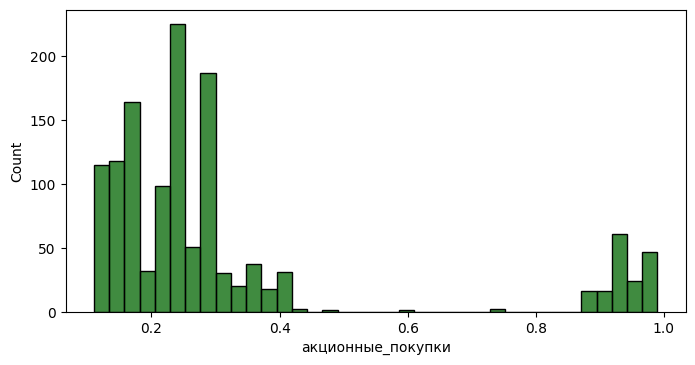

In [57]:
fig, axes = plt.subplots(figsize=(8,4), dpi=100)
sns.histplot(data=df_segment['акционные_покупки'], color='darkgreen',ax=axes);

На графике распределения виден пик > 0.8 - т.е. явно выделяется группа покупателей предпочитающих преимущественно акционные товары.

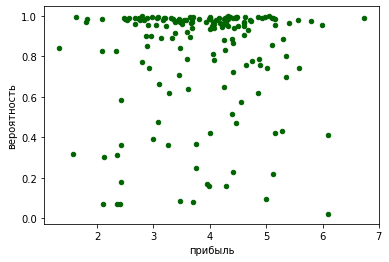

In [58]:
df_segment.query('акционные_покупки>0.8').plot(x='прибыль', y='вероятность', kind='scatter', color='darkgreen');

На диаграмме рассеяности видим, корелляции между предпочтением к ационным покупкам и прибылью нет, но вот вероятность снижения активности покупателей, предпочитающих акции, весьма велика.

In [59]:
# покупатель у которых высок рикс снижения активности
new_segment = df_segment.query('акционные_покупки>0.8 & вероятность>0.5')
# покупатели с постоянной активностью
new_segment_const = df_segment.query('акционные_покупки>0.8 & вероятность<=0.5')
new_segment.sample(5)

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_03_мес,выручка_за_02_мес,выручка_за_01_мес,минут_за_02_мес,минут_за_01_мес,покупательская_активность,вероятность,прогноз_покуп_активности,прибыль
1093,216445,стандарт,да,4.9,5,307,0.99,Техника для красоты и здоровья,1,2,6,9,4351.0,3061.0,4309.0,18,9,Прежний уровень,0.708862,Снизится,3.45
195,215547,премиум,нет,2.6,3,308,0.89,Домашний текстиль,2,8,6,5,4655.0,5274.5,5199.1,14,10,Снизилась,0.985924,Снизится,3.45
120,215472,стандарт,нет,2.4,4,186,0.93,Косметика и аксесуары,3,6,3,4,4596.0,5920.5,6099.9,11,8,Снизилась,0.988834,Снизится,4.47
347,215699,стандарт,нет,4.1,3,811,0.93,Косметика и аксесуары,4,1,5,8,4518.0,4441.5,4194.5,12,14,Снизилась,0.649019,Снизится,4.25
252,215604,стандарт,нет,3.1,5,458,0.99,Косметика и аксесуары,1,5,3,4,4308.0,4449.0,4459.4,8,10,Снизилась,0.995476,Снизится,4.86


Активность снизится - 137
Активность останется на прежнем уровне - 27


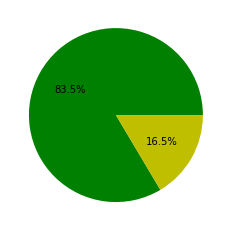

In [60]:
print('Активность снизится -', new_segment['id'].count())
print('Активность останется на прежнем уровне -', new_segment_const['id'].count())
fig, axes = plt.subplots()
axes.pie(x=[new_segment['id'].count(), new_segment_const['id'].count()], autopct='%.1f%%', colors=['g', 'y']);

Более 80% покупателей предпочитающих акционные товары - снизят свою покупательскую активность.

Общая прибыль -  5181.0199999999995
Прибыль от клиентов с высокой вероятностью снижения-  533.35


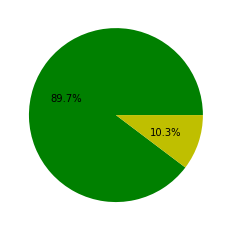

In [61]:
print('Общая прибыль - ', df_segment['прибыль'].sum())
print('Прибыль от клиентов с высокой вероятностью снижения- ', new_segment['прибыль'].sum())
fig, axes = plt.subplots()
axes.pie(x=[(df_segment['прибыль'].sum()-new_segment['прибыль'].sum()), new_segment['прибыль'].sum()], autopct='%.1f%%', colors=['g', 'y']);

Доля данного сегмента покупателй в общей прибыли магазина 10.3% - довольно существенно.

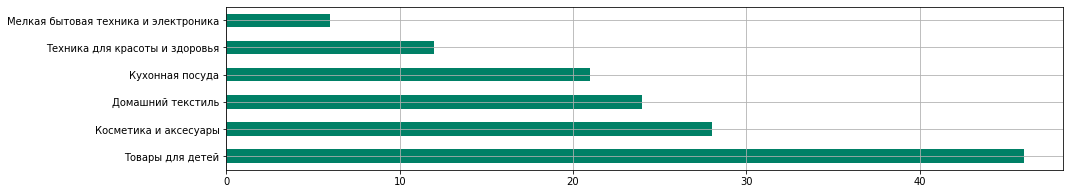

In [62]:
# рассмотрим распределение покупок выбранного сегмента для признака популярная категория
new_segment['популярная_категория'].value_counts().plot(kind='barh',
              colormap='summer',
              figsize=(15, 3),             
              grid=True);

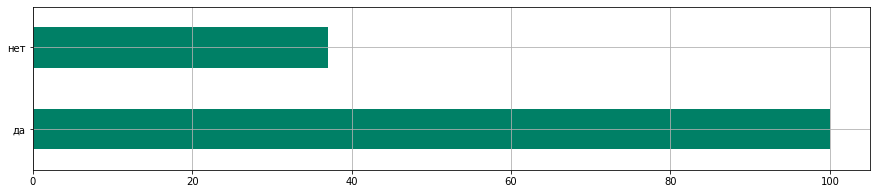

In [63]:
# рассмотрим распределение покупок выбранного сегмента для признака разрешить сообщать
new_segment['разрешить_сообщать'].value_counts().plot(kind='barh',
              colormap='summer',
              figsize=(15, 3),             
              grid=True);

По графикам можно сделать вывод, что наиболее популяркая категория товаров у выбранного сегмента клиентов это товары для детей, а так же косметика и аксессуары. При этом подавляющее большинство клиентов не против рекламных рассылок.



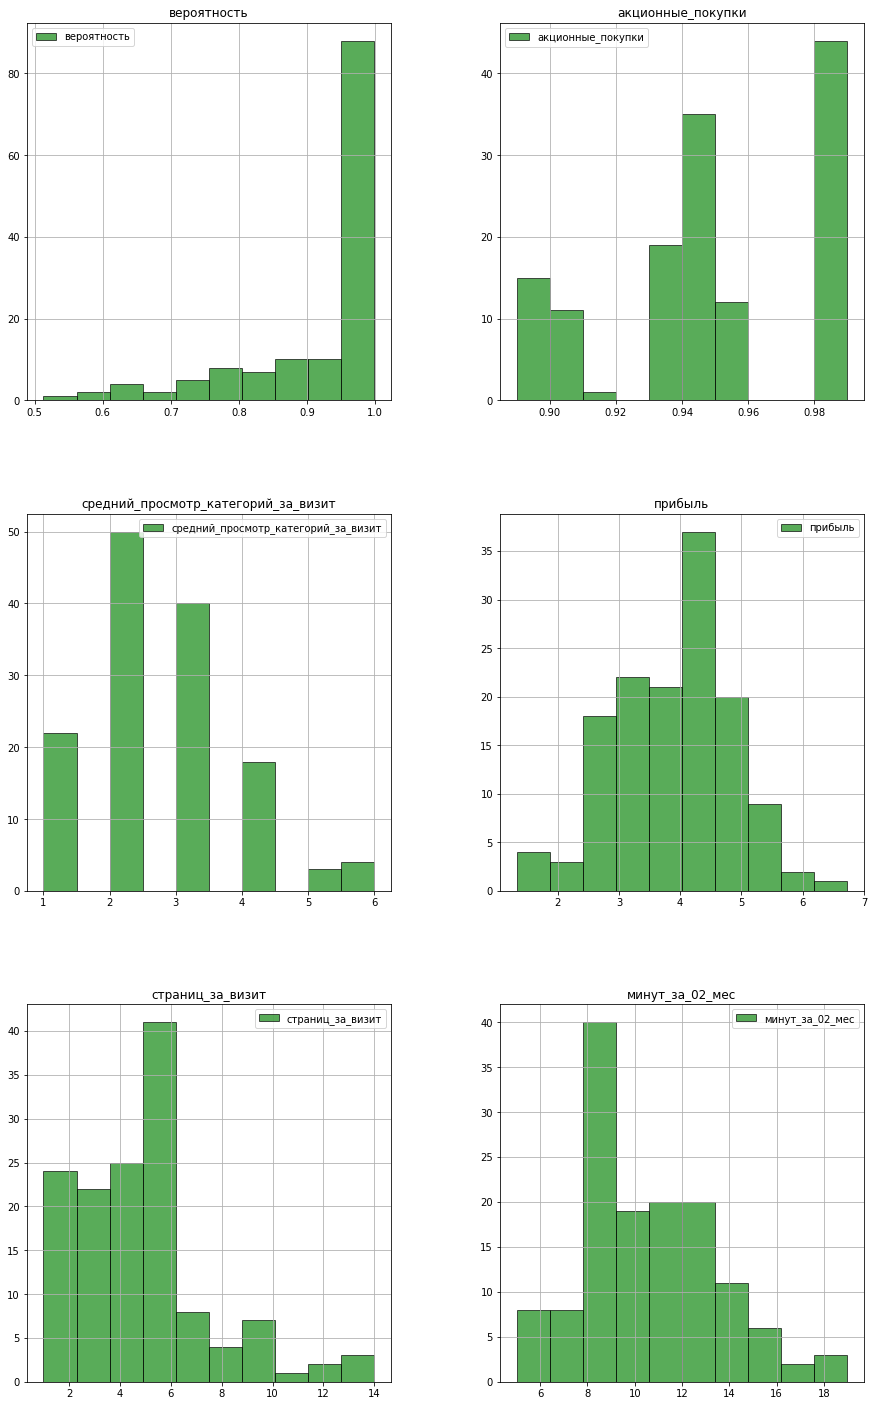

In [64]:
# рассмотрим наиболее важные количественные признаки для выбранного сегмента
new_segment[['вероятность', 'акционные_покупки',
            'средний_просмотр_категорий_за_визит','прибыль',
            'страниц_за_визит', 'минут_за_02_мес']
           ].hist(bins=10, ec='black', lw=1, alpha=0.65, legend=True, figsize=(15, 25), color='g');

Из графиков можем сделать выводы, что:

    - вероятность снижения активности у клиентов предпочитающих товары по скидкам очень велика, подавляющее большинство
    (более 65%) с высокой вероятностью начнет совершать меньше покупок или прекратит совсем;
    - основную часть выбранного сегмента представляют покупатели, кто берет исключительно акционные товары;
    - чаще всего рассматривается 2 категории(или 5 страниц) за визит(т.е. люди смотрят какие-то конкретные товары, зная что именно им необходимо), это вероятнее всего не спонтанные покупки;
    - на просмотр в основном тратится около 8 минут, реже 10-14;
    - прибыль от данныжх покупателей не отличается по распределению и средним от общей массы клиентов.


Промежуточные выводы.


В целом по выбранному нами сегменту, можно сделать предварительный вывод, что для удержания клиентов и поддержания их уровня покупательской активности следует:

 - удержать клиента на сайте дольше и заставить просмотреть больше страниц, средний показклеть в 8 минут - небольшой, его следует постараться увеличить, для этого размещать непосредственно на странице рассматриеваемого товара ссылки на сопутствующие товары;
 - разработать больше предложения комплексных покупок со скидкой(товар + сопуствующий товар = скидка);
 - так как в основном клиенты знают за каким конкретным товаром приходят на сайт (просматривают конкретные категории) - предложить акции по количеству товаров(учитывая, что часто это детские товары, крупные закупки впрок вполне возможны);
 - большая часть покупателей лояльна к рекламным рассылкам, значит вполне возможно их увеличение с вышеизложенными предложениями.
 - добавить купоны на персональные скидки на дальнейшие покупки(важен сам факт купона и скидки, а не ее размер).

## Итоговые выводы

**Общий вывод по данным:**

 - загружены имеющиеся данные из 4 файлов (market_file.csv, market_money.csv, money.csv, market_time.csv);
 - приведены названия колонок к единому виду(строчные буквы и змеиный регистр);
 - пропусков в данных не обнаружено, типизация данных во всех датафреймах корректна;
 
 
 - предобработка данных:
    - явные дубликаты не обнаружены;
    - исправлены неявные дубликаты названий в df_market_file и опечатки в df_market_time;
 
 - исследовательский анализ данных: 
    - рассмотрели распределение количественных и качественых признаков в каждом датафрейме;
    - исключили выбросы, лишние для исследования данные;
    - обьединили данные в один датафрейм для удобства исследования, привели названия к удобночитаемой форме;
 
 - провели корреляционный анализ, мультикоолинеарность обнаруена не была, отметили признаки с наибольшей корреляцией:
    - 'страниц за визит' - 0.75;
    - 'минут_за_02_мес' - 0.69;
    
 - использовали пайплайны:
    - закодировали целевой признак;
    - провели стратификацию;
    - построили пайплайн с моделями KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(), спользуя различные гиперпаметры для каждой;
    - по итогу выделили самую успешную модель:
        - LogisticRegression с параметром solver='liblinear' и лассо-регуляризацией;
        - гиперпараметр C=2;
        - скалером MinMaxScaler().
        
 - проанализировали важность признаков:
     - обучили лучшую модель на имеющихся данных;
     - расссмотрели вклад всех признаков в модель и выявили самы важные:
          - 'страниц_за_визит';
          - 'средний_просмотр_категорий_за_визит';
          - 'акционные_покупки'.
          
- выбрали сегмент покупателей для исследования:
     - проанализировали сегмент клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности;
     - разработали решение, которое позволит персонализировать предложения постоянным клиентам:
         - удержать клиента на сайте дольше и заставить просмотреть больше страниц, для этого размещать непосредственно на странице рассматриеваемого товара ссылки на сопутствующие товары;
         - разработать больше предложения комплексных покупок со скидкой(товар + сопуствующий товар = скидка);
         - так как в основном клиенты знают за каким конкретным товаром приходят на сайт (просматривают конкретные категории) - предложить акции по количеству товаров(учитывая, что часто это детские товары, крупные закупки впрок вполне возможны);
         - большая часть покупателей лояльна к рекламным рассылкам, значит вполне возможно их увеличение с вышеизложенными предложениями.
         - добавить купоны на персональные скидки на дальнейшие покупки(важен сам факт купона и скидки, а не ее размер).